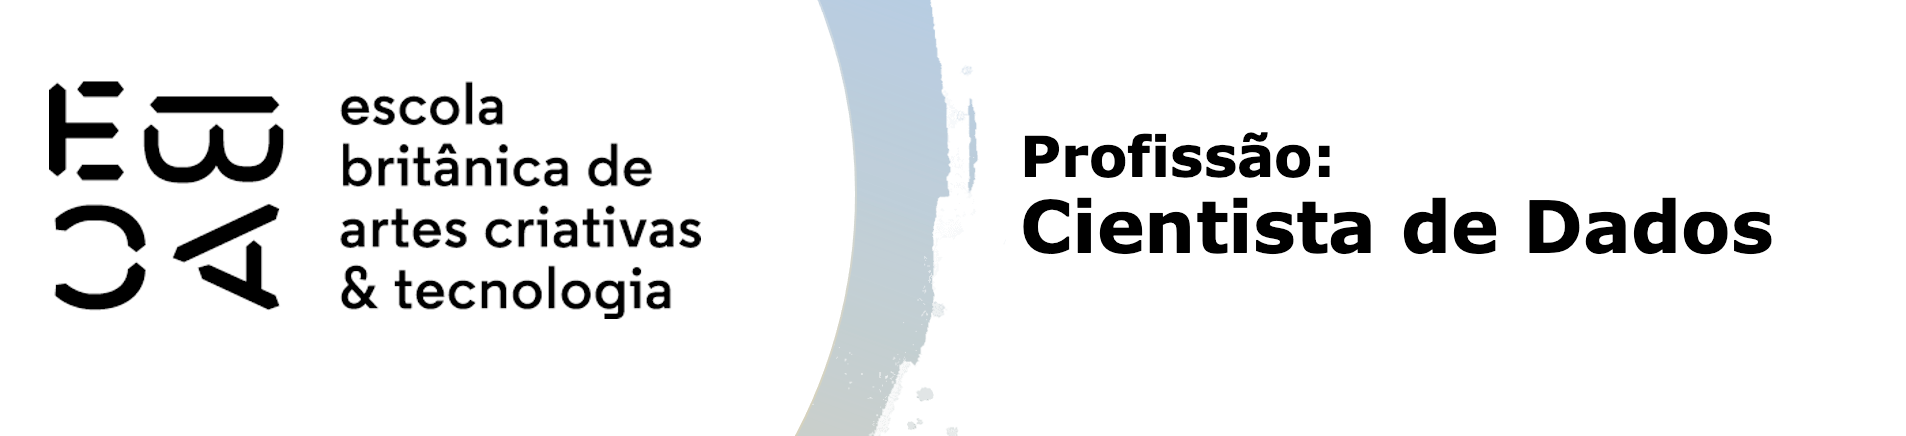

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [114]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t
from scipy import stats

from boruta import BorutaPy

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,  LabelEncoder
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from pycaret.classification import *
from pycaret.utils.generic import check_metric

import warnings;   warnings.filterwarnings("ignore")

In [2]:
df_original = pd.read_feather('credit_scoring.ftr')
df_original.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [3]:
df_original['mau'] = df_original['mau'].astype('int64')
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [4]:
print(df_original.data_ref.unique())

['2015-01-01T00:00:00.000000000' '2015-02-01T00:00:00.000000000'
 '2015-03-01T00:00:00.000000000' '2015-04-01T00:00:00.000000000'
 '2015-05-01T00:00:00.000000000' '2015-06-01T00:00:00.000000000'
 '2015-07-01T00:00:00.000000000' '2015-08-01T00:00:00.000000000'
 '2015-09-01T00:00:00.000000000' '2015-10-01T00:00:00.000000000'
 '2015-11-01T00:00:00.000000000' '2015-12-01T00:00:00.000000000'
 '2016-01-01T00:00:00.000000000' '2016-02-01T00:00:00.000000000'
 '2016-03-01T00:00:00.000000000']


In [5]:
df = df_original[(df_original['data_ref'] >= '2015-01-01') & (df_original['data_ref'] <= '2015-12-01')]
df.drop(columns=['index', 'data_ref'], inplace = True)
print(df.shape)
df.head(2)

(600000, 13)


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,0
1,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,0


In [6]:
df_test = df_original[df_original['data_ref'] >= '2016-01-01']
df_test.drop(columns=['index', 'data_ref'], inplace = True)
print(df_test.shape)
df_test.head(2)

(150000, 13)


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
600000,F,S,S,2,Assalariado,Superior completo,Casado,Casa,38,7.383562,4.0,2969.49,1
600001,F,N,S,0,Assalariado,Médio,Casado,Casa,55,8.471233,2.0,6278.37,0


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [7]:
for coluna in df:
    print(df[coluna].value_counts())
    print(df[coluna].describe())
    print('\n')

F    403805
M    196195
Name: sexo, dtype: int64
count     600000
unique         2
top            F
freq      403805
Name: sexo, dtype: object


N    366293
S    233707
Name: posse_de_veiculo, dtype: int64
count     600000
unique         2
top            N
freq      366293
Name: posse_de_veiculo, dtype: object


S    403054
N    196946
Name: posse_de_imovel, dtype: int64
count     600000
unique         2
top            S
freq      403054
Name: posse_de_imovel, dtype: object


0     413882
1     122471
2      55603
3       6960
4        854
7         82
5         77
14        71
Name: qtd_filhos, dtype: int64
count    600000.000000
mean          0.433210
std           0.739869
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          14.000000
Name: qtd_filhos, dtype: float64


Assalariado         308460
Empresário          138141
Pensionista         101127
Servidor público     51981
Bolsista               291
Name: tipo_renda, dtype: int64

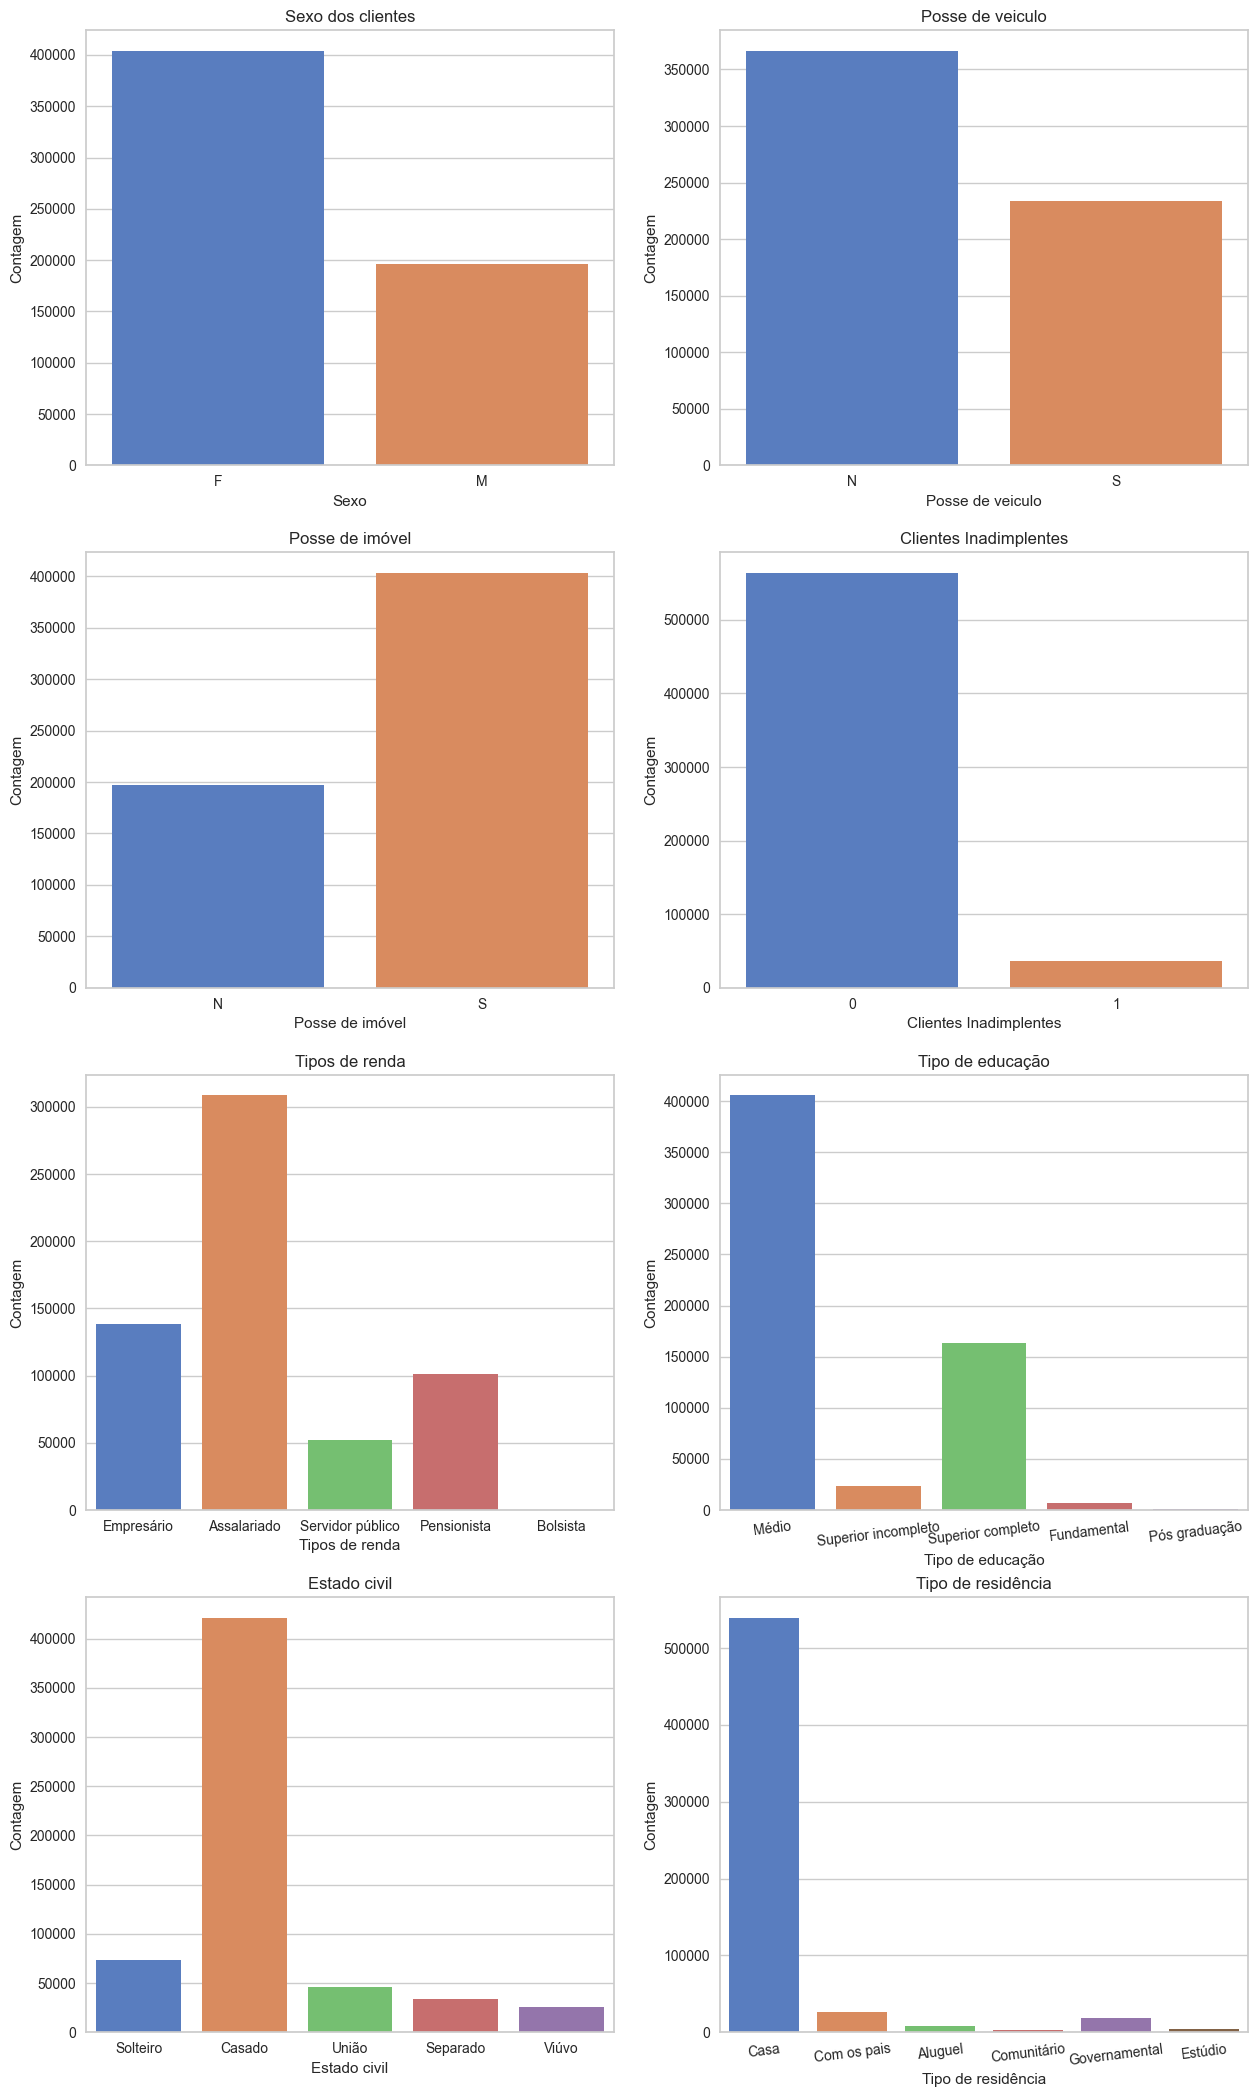

In [8]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15,26))

sns.countplot(data=df, x='sexo', palette='muted', ax=ax[0,0])
ax[0,0].set_title('Sexo dos clientes')
ax[0,0].set_xlabel('Sexo')
ax[0,0].set_ylabel('Contagem')

sns.countplot(data=df, x='posse_de_veiculo', palette='muted', ax=ax[0,1])
ax[0,1].set_title('Posse de veiculo')
ax[0,1].set_xlabel('Posse de veiculo')
ax[0,1].set_ylabel('Contagem')

sns.countplot(data=df, x='posse_de_imovel', palette='muted', ax=ax[1,0])
ax[1,0].set_title('Posse de imóvel')
ax[1,0].set_xlabel('Posse de imóvel')
ax[1,0].set_ylabel('Contagem')

sns.countplot(data=df, x='mau', palette='muted', ax=ax[1,1])
ax[1,1].set_title('Clientes Inadimplentes')
ax[1,1].set_xlabel('Clientes Inadimplentes')
ax[1,1].set_ylabel('Contagem')

sns.countplot(data=df, x='tipo_renda', palette='muted', ax=ax[2,0])
ax[2,0].set_title('Tipos de renda')
ax[2,0].set_xlabel('Tipos de renda')
ax[2,0].set_ylabel('Contagem')

sns.countplot(data=df, x='educacao', palette='muted', ax=ax[2,1])
ax[2,1].set_title('Tipo de educação')
ax[2,1].set_xlabel('Tipo de educação')
ax[2,1].set_ylabel('Contagem')
for tick in ax[2,1].get_xticklabels():
    tick.set_rotation(7)

sns.countplot(data=df, x='estado_civil',  palette='muted', ax=ax[3,0])
ax[3,0].set_title('Estado civil')
ax[3,0].set_xlabel('Estado civil')
ax[3,0].set_ylabel('Contagem')

sns.countplot(data=df, x='tipo_residencia', palette='muted', ax=ax[3,1])
ax[3,1].set_title('Tipo de residência')
ax[3,1].set_xlabel('Tipo de residência')
ax[3,1].set_ylabel('Contagem')
for tick in ax[3,1].get_xticklabels():
    tick.set_rotation(7)

<AxesSubplot: xlabel='idade', ylabel='count'>

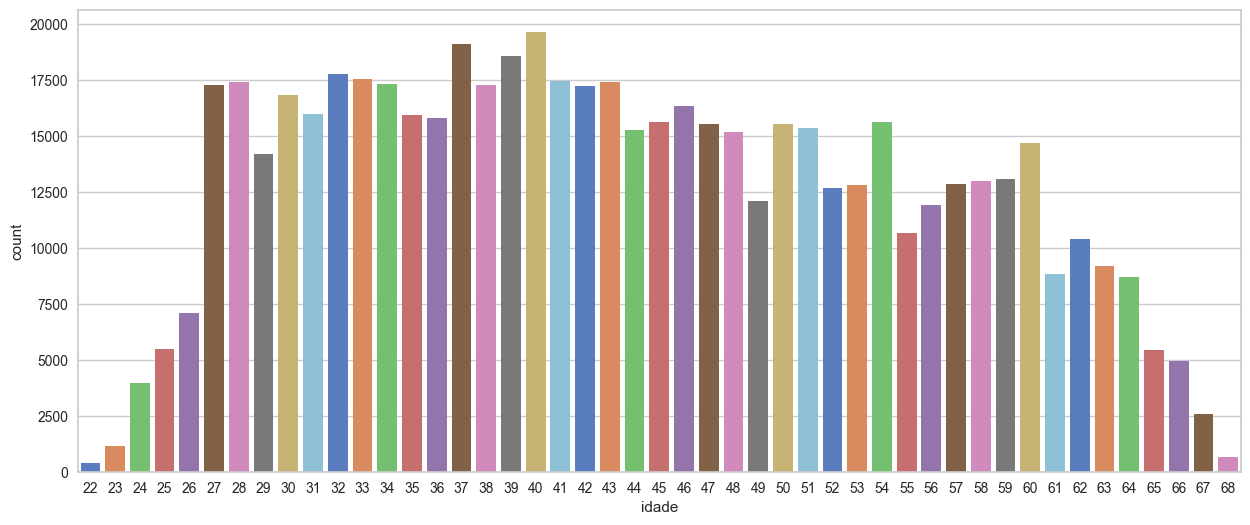

In [9]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x='idade', palette='muted')

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

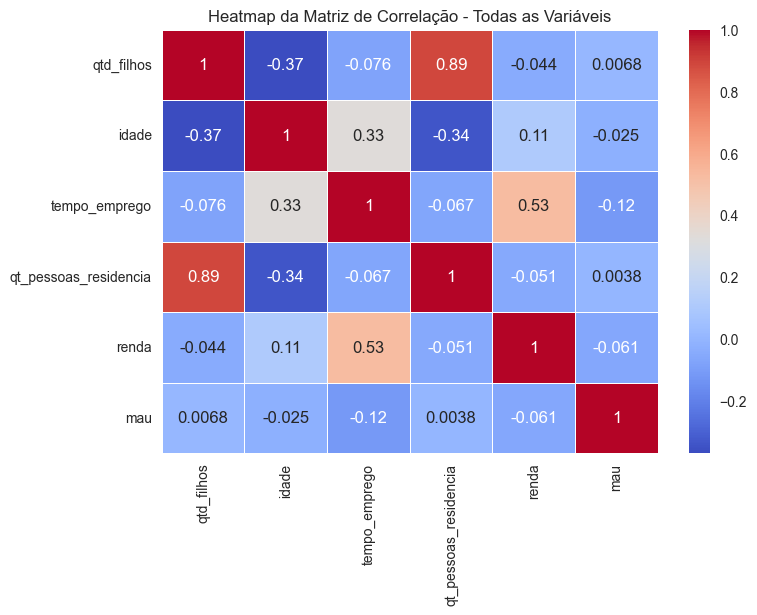

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
qtd_filhos,1.000000,-0.369892,-0.075889,0.890439,-0.044429,0.006810
idade,-0.369892,1.000000,0.330744,-0.341117,0.108172,-0.025322
tempo_emprego,-0.075889,0.330744,1.000000,-0.066921,0.526759,-0.118012
qt_pessoas_residencia,0.890439,-0.341117,-0.066921,1.000000,-0.050763,0.003806
renda,-0.044429,0.108172,0.526759,-0.050763,1.000000,-0.061277
mau,0.006810,-0.025322,-0.118012,0.003806,-0.061277,1.000000


In [10]:
# Correlação com as variaveis qualitativas
df_num = df.select_dtypes(include=['float64', 'int64'])
correlação = df_num.corr()

sns.heatmap(correlação, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Heatmap da Matriz de Correlação - Todas as Variáveis")
plt.show()
correlação

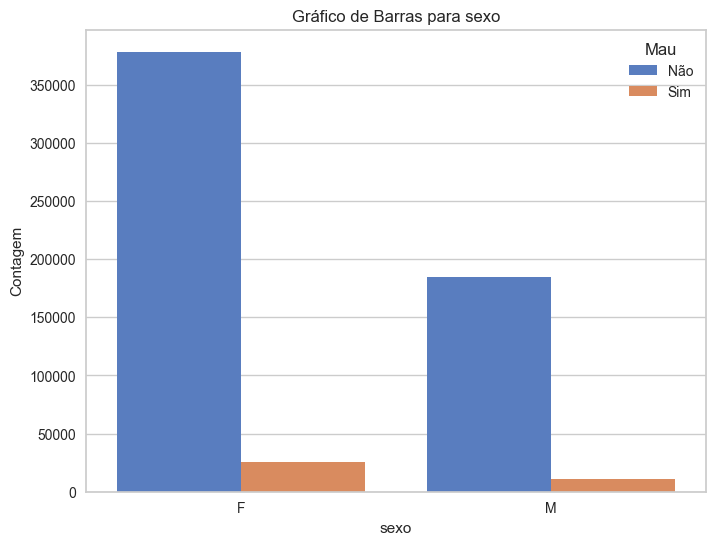

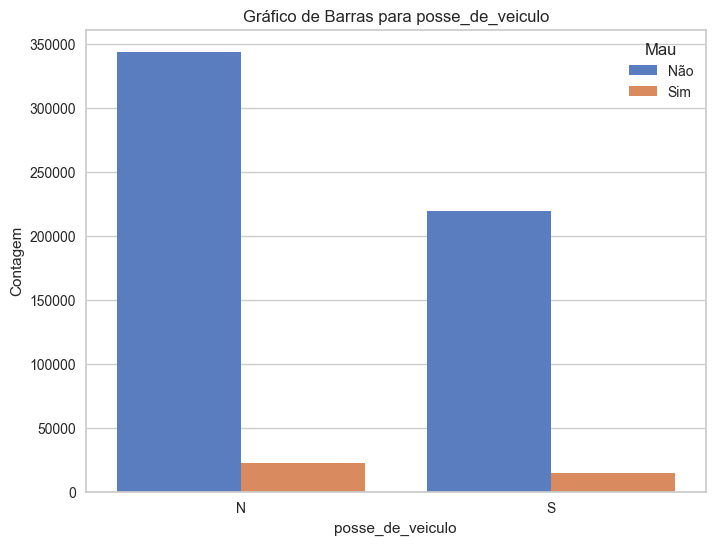

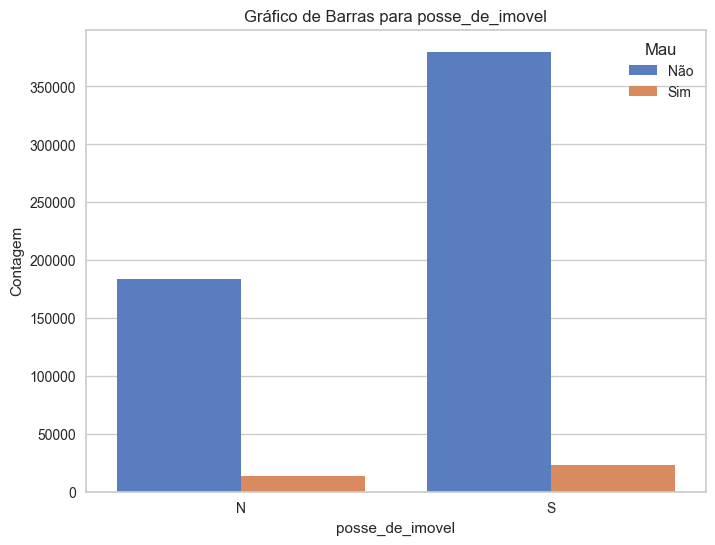

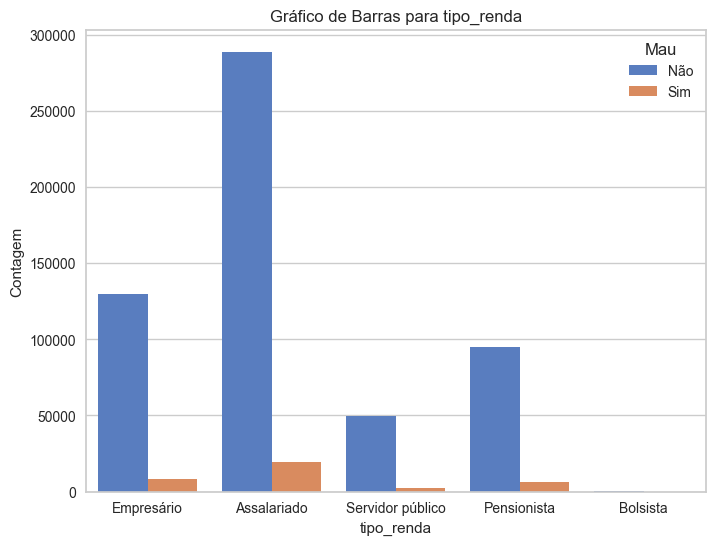

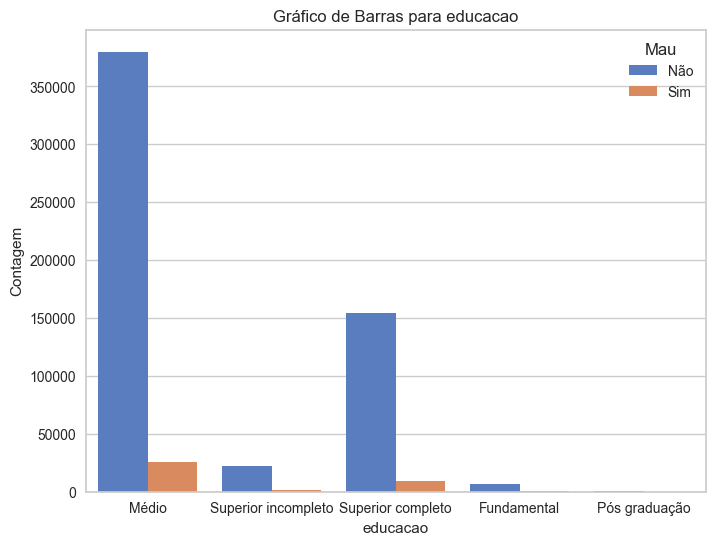

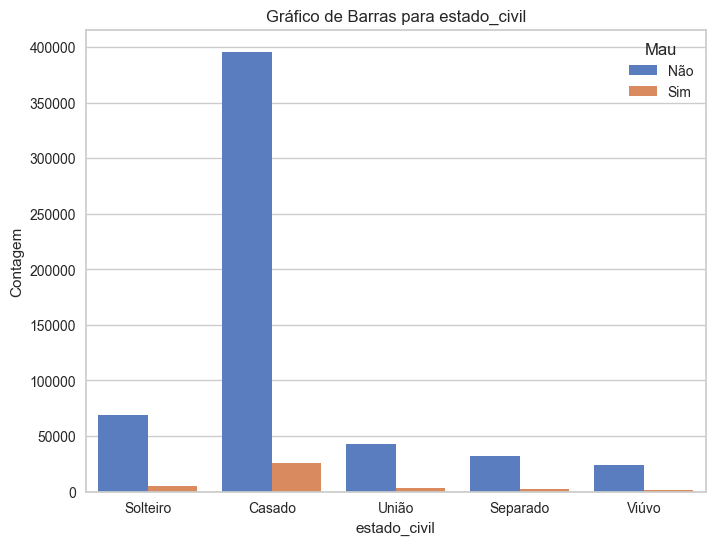

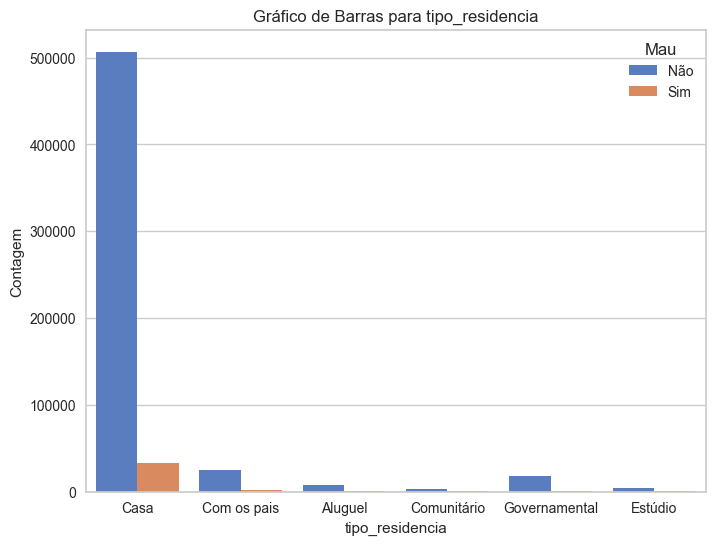

In [11]:
variaveis_qualitativas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 
                          'estado_civil', 'tipo_residencia']
for variavel in variaveis_qualitativas:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=variavel, hue='mau', data=df, palette='muted')
    plt.xlabel(variavel)
    plt.ylabel('Contagem')
    plt.title(f'Gráfico de Barras para {variavel}')
    plt.legend(title='Mau', labels=['Não', 'Sim'])
    plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [12]:
# Trato de valores missings
missing_values = df.isnull().sum()
missing_values

sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            100875
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [13]:
faltantes = missing_values.tempo_emprego
print(f'Como há cerca de {faltantes} dados faltantes, que correspondem a {faltantes/df.shape[0]*100:.2f}%, iremos substituir pela média para evitar uma perda significativa de informações.')

Como há cerca de 100875 dados faltantes, que correspondem a 16.81%, iremos substituir pela média para evitar uma perda significativa de informações.


In [14]:
media_tempo_emprego = df['tempo_emprego'].mean()
df['tempo_emprego'] = df['tempo_emprego'].fillna(media_tempo_emprego)
df.isnull().sum()

sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64

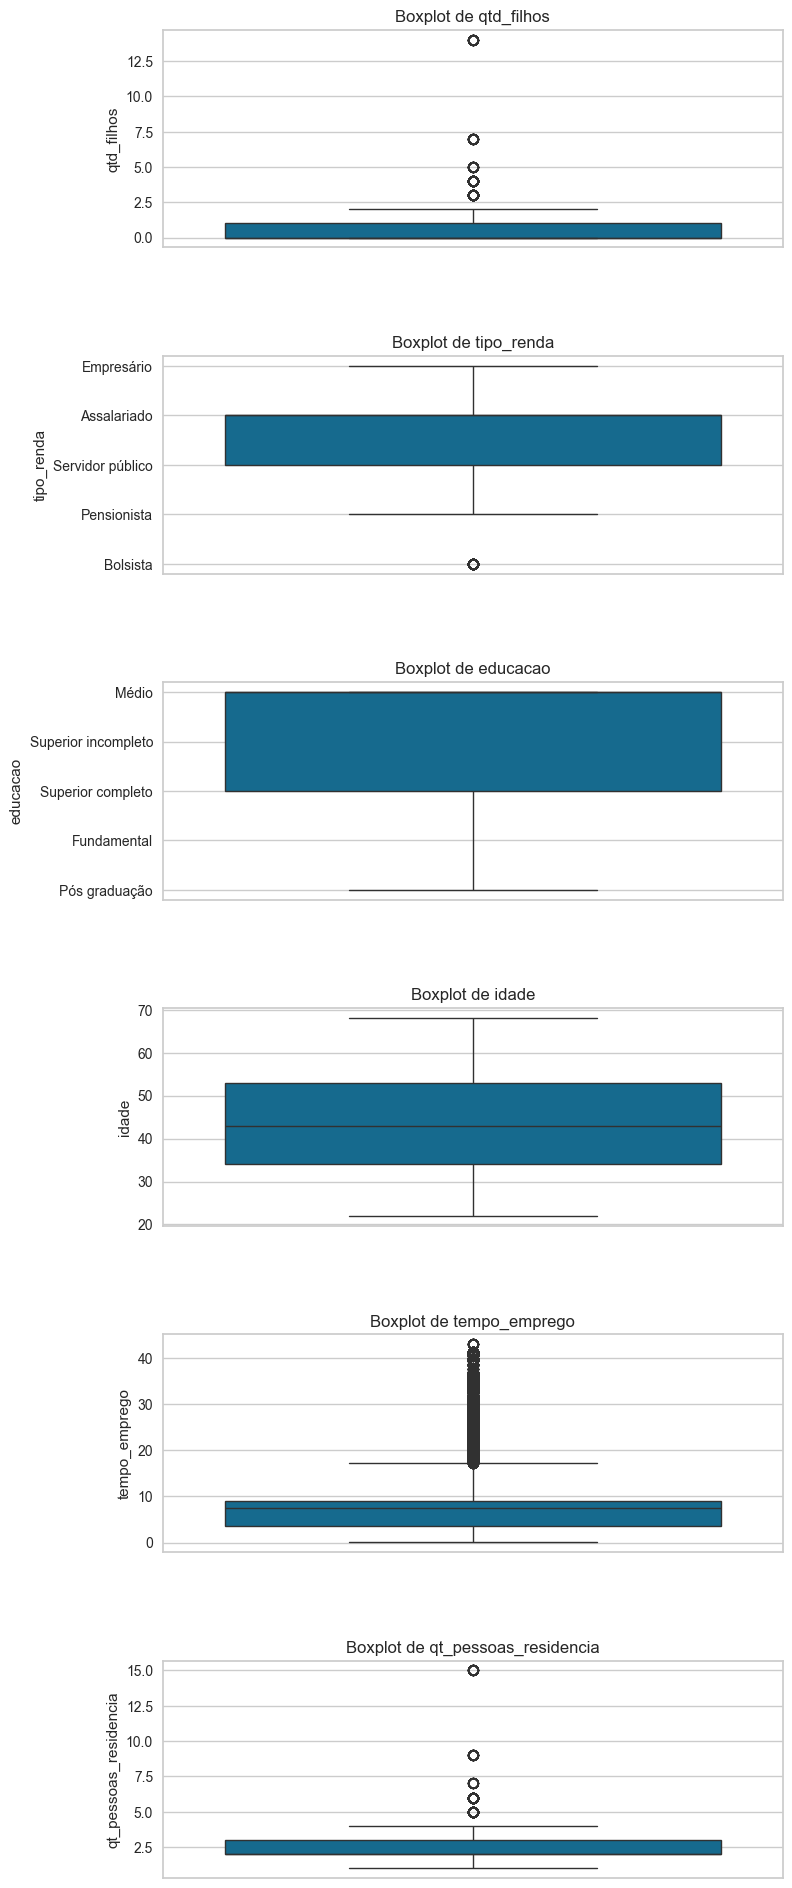

In [15]:
# Trato de valores outliers
variaveis_independentes = ['qtd_filhos', 'tipo_renda', 'educacao', 
                           'idade', 'tempo_emprego', 'qt_pessoas_residencia']

fig, axes = plt.subplots(nrows=len(variaveis_independentes), ncols=1, figsize=(8, 4 * len(variaveis_independentes)))
plt.subplots_adjust(wspace=0.4, hspace=0.5)
for i, var in enumerate(variaveis_independentes):
    sns.boxplot(y=var, data=df, ax=axes[i])
    axes[i].set_title(f'Boxplot de {var}')

plt.show()

Analisando as variáveis, notamos que há alguns outliers, principalmente na variável 'tempo_emprego'. No exercício do Módulo 35, identificamos que esses casos podem ocorrer no mundo real e, por isso, eu não consideraria esses indivíduos como outliers.

In [16]:
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados['unicos'] = df.nunique()

In [17]:
# Função IV
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

# Populando o metadados
for var in metadados[metadados.papel == 'covariavel'].index:
    if pd.api.types.is_numeric_dtype(df[var]):
        if metadados.loc[var, 'unicos'] > 50:
            metadados.loc[var, 'IV'] = IV(pd.qcut(df[var], 5, duplicates='drop'), df.mau)
        else:
            metadados.loc[var, 'IV'] = IV(df[var], df.mau)
    else:
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)

In [18]:
metadados.loc[metadados['IV'] < 0.02, 'poder_preditivo'] = 'Irrelevante'
metadados.loc[(metadados['IV'] >= 0.02) & (metadados['IV'] <= 0.1), 'poder_preditivo'] = 'Fraco'
metadados.loc[(metadados['IV'] > 0.1) & (metadados['IV'] <= 0.3), 'poder_preditivo'] = 'Médio'
metadados.loc[(metadados['IV'] > 0.3) & (metadados['IV'] <= 0.5), 'poder_preditivo'] = 'Forte'
metadados.loc[metadados['IV'] > 0.5, 'poder_preditivo'] = 'Atenção, muito alto'
metadados

,dtype,nmissing,papel,unicos,IV,poder_preditivo
sexo,object,0,covariavel,2,0.002665,Irrelevante
posse_de_veiculo,object,0,covariavel,2,0.000075,Irrelevante
posse_de_imovel,object,0,covariavel,2,0.009690,Irrelevante
qtd_filhos,int64,0,covariavel,8,0.001689,Irrelevante
tipo_renda,object,0,covariavel,5,0.009718,Irrelevante
educacao,object,0,covariavel,5,0.003690,Irrelevante
estado_civil,object,0,covariavel,5,0.001305,Irrelevante
tipo_residencia,object,0,covariavel,6,0.003330,Irrelevante
idade,int64,0,covariavel,47,0.025662,Fraco
tempo_emprego,float64,0,covariavel,3005,0.283956,Médio


In [19]:
from IPython.display import display

def biv_discreta(var, df):
    df['bom'] = 1 - df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau': g['mau'].mean(),
                        var: g['mau'].mean().index,
                        'cont': g[var].count()})
    
    biv['ep'] = (biv.mau * (1 - biv.mau) / biv.cont) ** .5
    biv['mau_sup'] = biv.mau + t.ppf([0.975], biv.cont - 1) * biv.ep
    biv['mau_inf'] = biv.mau + t.ppf([0.025], biv.cont - 1) * biv.ep
    
    biv['logit'] = np.log(biv.mau / (1 - biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup / (1 - biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf / (1 - biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral
    
    print(f"\nDistribuição de {var}:\n")
    display(df[var].value_counts())

    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat - .7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    plt.subplots_adjust(hspace=0.5)

    ax[1] = biv.cont.plot.bar()
    
    display(biv)
    
    return biv

In [20]:
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral
    
    print(f"\nDistribuição de {var}:\n")
    display(df[var].value_counts())

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    
    display(biv)

    return None

In [21]:
df.columns

Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos',
       'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'idade',
       'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'mau'],
      dtype='object')


Distribuição de sexo:



F    403805
M    196195
Name: sexo, dtype: int64

,qt_bom,qt_mau,mau,sexo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,,
F,378318,25487,0.063117,F,403805,0.000383,0.063867,0.062367,-2.697567,-2.684953,-2.710321,0.035125,0.047739,0.02237
M,185039,11156,0.056862,M,196195,0.000523,0.057887,0.055837,-2.808589,-2.789641,-2.827861,-0.075898,-0.056950,-0.09517


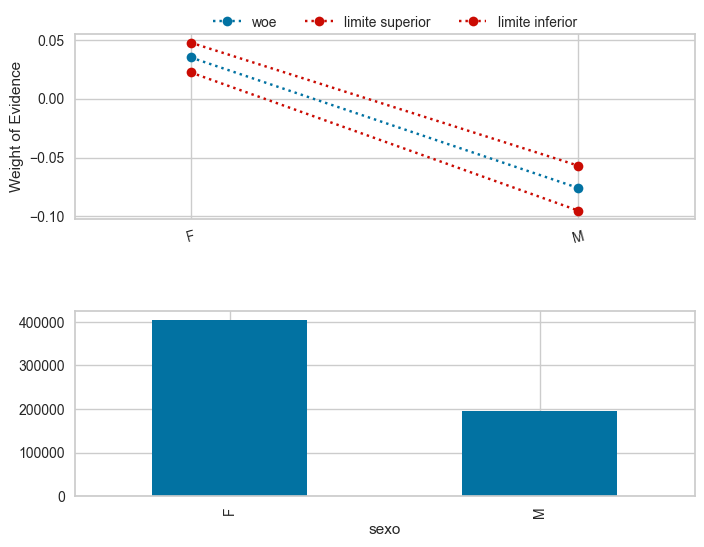

In [22]:
biv_discreta('sexo', df);


Distribuição de posse_de_veiculo:



N    366293
S    233707
Name: posse_de_veiculo, dtype: int64

,qt_bom,qt_mau,mau,posse_de_veiculo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_veiculo,,,,,,,,,,,,,,
N,343778,22515,0.061467,N,366293,0.000397,0.062245,0.060689,-2.725814,-2.712410,-2.739378,0.006877,0.020281,-0.006687
S,219579,14128,0.060452,S,233707,0.000493,0.061418,0.059486,-2.743553,-2.726667,-2.760694,-0.010862,0.006024,-0.028003


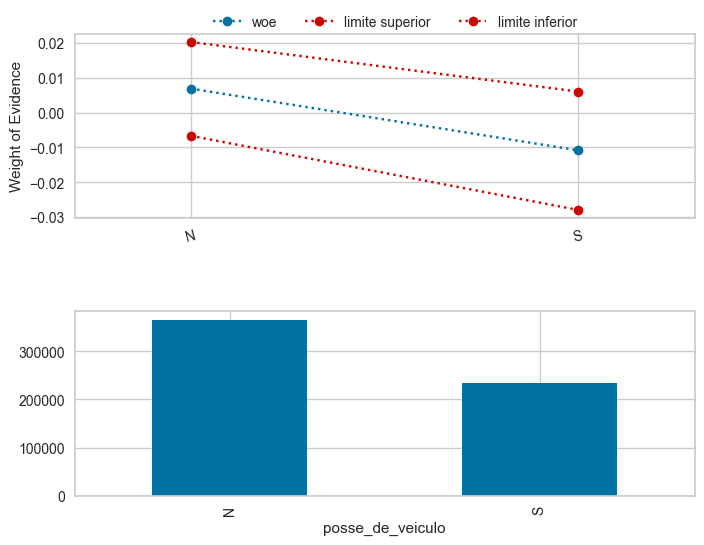

In [23]:
biv_discreta('posse_de_veiculo', df);


Distribuição de posse_de_imovel:



S    403054
N    196946
Name: posse_de_imovel, dtype: int64

,qt_bom,qt_mau,mau,posse_de_imovel,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_imovel,,,,,,,,,,,,,,
N,183305,13641,0.069263,N,196946,0.000572,0.070384,0.068141,-2.598071,-2.580806,-2.615598,0.134620,0.151885,0.117093
S,380052,23002,0.057069,S,403054,0.000365,0.057785,0.056353,-2.804727,-2.791496,-2.818114,-0.072036,-0.058805,-0.085423


,qt_bom,qt_mau,mau,posse_de_imovel,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_imovel,,,,,,,,,,,,,,
N,183305,13641,0.069263,N,196946,0.000572,0.070384,0.068141,-2.598071,-2.580806,-2.615598,0.134620,0.151885,0.117093
S,380052,23002,0.057069,S,403054,0.000365,0.057785,0.056353,-2.804727,-2.791496,-2.818114,-0.072036,-0.058805,-0.085423


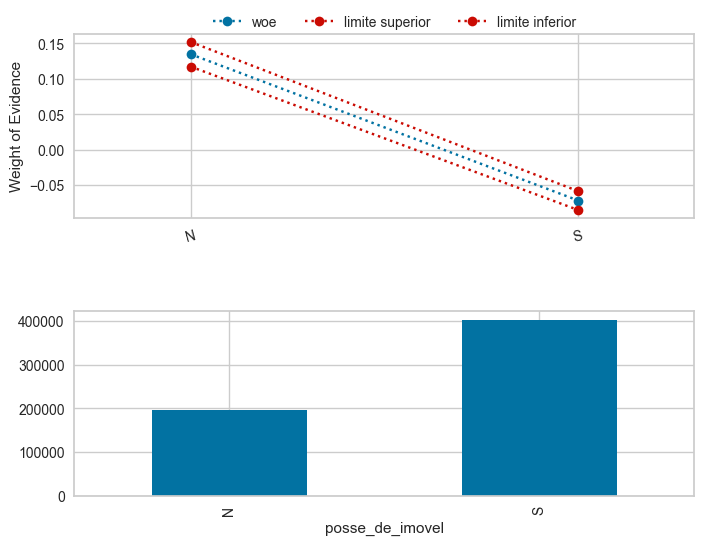

In [24]:
biv_discreta('posse_de_imovel', df)


Distribuição de qtd_filhos:



0     413882
1     122471
2      55603
3       6960
4        854
7         82
5         77
14        71
Name: qtd_filhos, dtype: int64

,qt_bom,qt_mau,mau,qtd_filhos,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qtd_filhos,,,,,,,,,,,,,,
0,389129,24753,0.059807,0,413882,0.000369,0.060529,0.059084,-2.754964,-2.742189,-2.767885,-0.022273,-0.009497,-0.035194
1,114547,7924,0.064701,1,122471,0.000703,0.066079,0.063323,-2.671089,-2.648545,-2.694085,0.061602,0.084147,0.038606
2,52182,3421,0.061525,2,55603,0.001019,0.063523,0.059528,-2.724805,-2.690727,-2.759933,0.007886,0.041964,-0.027241
3,6493,467,0.067098,3,6960,0.002999,0.072977,0.061219,-2.632151,-2.541841,-2.730127,0.100540,0.190850,0.002564
4,806,48,0.056206,4,854,0.007881,0.071675,0.040737,-2.820883,-2.561236,-3.159030,-0.088192,0.171455,-0.426339
5,67,10,0.129870,5,77,0.038309,0.206169,0.053571,-1.902108,-1.348173,-2.871687,0.830584,1.384518,-0.138996
7,69,13,0.158537,7,82,0.040334,0.238789,0.078284,-1.669157,-1.159328,-2.465897,1.063534,1.573363,0.266795
14,64,7,0.098592,14,71,0.035379,0.169154,0.028029,-2.212973,-1.591637,-3.546072,0.519718,1.141054,-0.813381


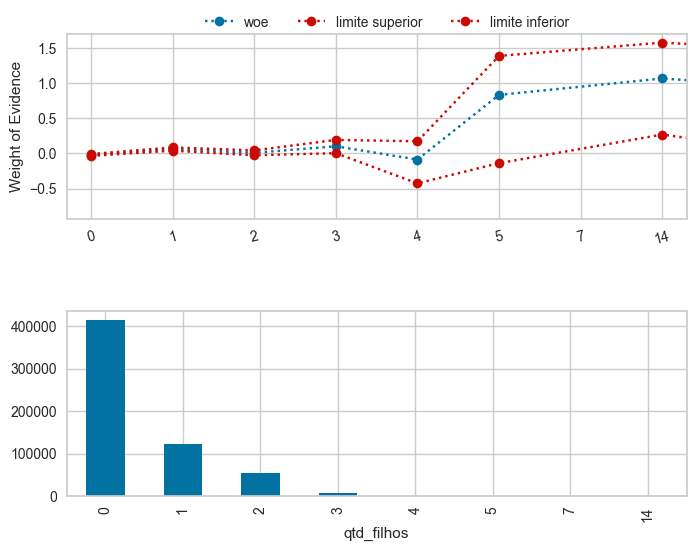

In [25]:
biv_discreta('qtd_filhos', df);


Distribuição de qtd_filhos:



0    413882
1    122471
2     55603
3      8044
Name: qtd_filhos, dtype: int64

,qt_bom,qt_mau,mau,qtd_filhos,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qtd_filhos,,,,,,,,,,,,,,
0,389129,24753,0.059807,0,413882,0.000369,0.060529,0.059084,-2.754964,-2.742189,-2.767885,-0.022273,-0.009497,-0.035194
1,114547,7924,0.064701,1,122471,0.000703,0.066079,0.063323,-2.671089,-2.648545,-2.694085,0.061602,0.084147,0.038606
2,52182,3421,0.061525,2,55603,0.001019,0.063523,0.059528,-2.724805,-2.690727,-2.759933,0.007886,0.041964,-0.027241
3,7499,545,0.067752,3,8044,0.002802,0.073245,0.062259,-2.621739,-2.537875,-2.712164,0.110952,0.194816,0.020528


0    413882
1    122471
2     55603
3      8044
Name: qtd_filhos, dtype: int64


0.001313822229647469

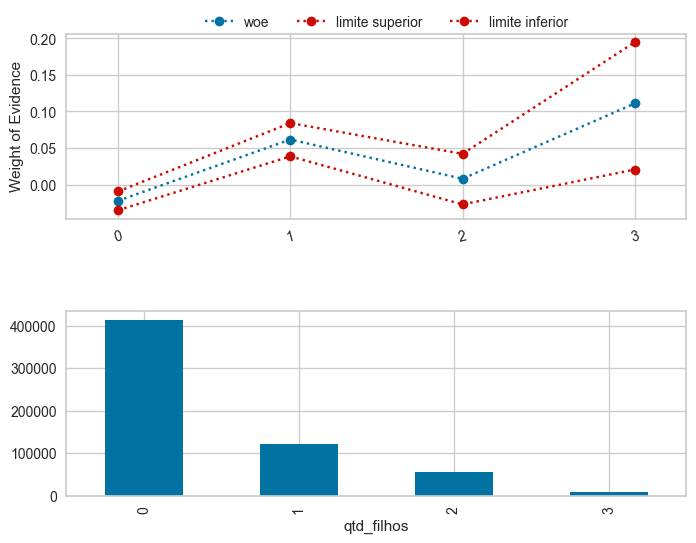

In [26]:
df.qtd_filhos.replace({4:3, 5:3, 7:3, 14:3}, inplace=True)

biv_discreta('qtd_filhos', df);
print(df.qtd_filhos.value_counts())
IV(df.qtd_filhos, df.mau)


Distribuição de tipo_renda:



Assalariado         308460
Empresário          138141
Pensionista         101127
Servidor público     51981
Bolsista               291
Name: tipo_renda, dtype: int64

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,288865,19595,0.063525,Assalariado,308460,0.000439,0.064386,0.062665,-2.690685,-2.676307,-2.705246,0.042006,0.056384,0.027445
Bolsista,279,12,0.041237,Bolsista,291,0.011656,0.064178,0.018296,-3.146305,-2.679758,-3.982616,-0.413614,0.052933,-1.249925
Empresário,129935,8206,0.059403,Empresário,138141,0.000636,0.060650,0.058157,-2.762169,-2.740076,-2.784700,-0.029478,-0.007385,-0.052009
Pensionista,94627,6500,0.064276,Pensionista,101127,0.000771,0.065787,0.062764,-2.678141,-2.653280,-2.703552,0.054550,0.079411,0.029139
Servidor público,49651,2330,0.044824,Servidor público,51981,0.000908,0.046603,0.043045,-3.059150,-3.018369,-3.101504,-0.326459,-0.285678,-0.368813


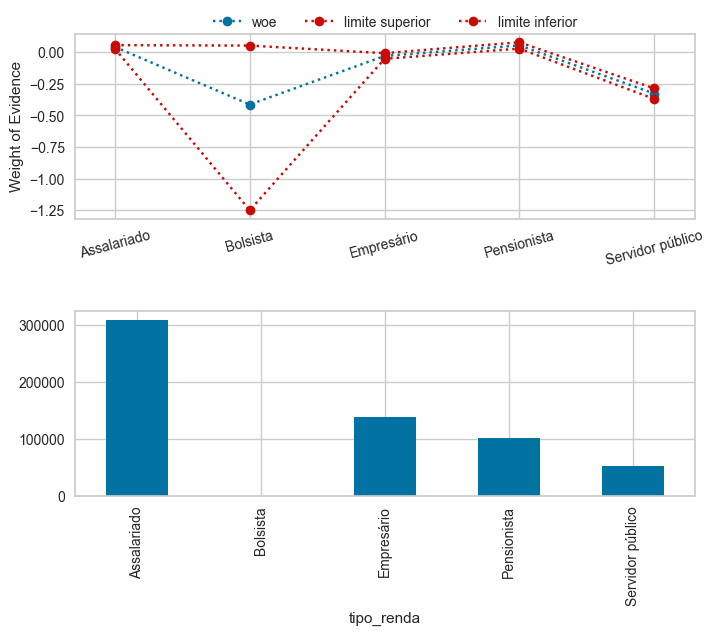

In [27]:
biv_discreta('tipo_renda', df);


Distribuição de tipo_renda:



Assalariado                    308460
Empresário                     138141
Pensionista                    101127
Servidor_público_e_Bolsista     52272
Name: tipo_renda, dtype: int64

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,288865,19595,0.063525,Assalariado,308460,0.000439,0.064386,0.062665,-2.690685,-2.676307,-2.705246,0.042006,0.056384,0.027445
Empresário,129935,8206,0.059403,Empresário,138141,0.000636,0.060650,0.058157,-2.762169,-2.740076,-2.784700,-0.029478,-0.007385,-0.052009
Pensionista,94627,6500,0.064276,Pensionista,101127,0.000771,0.065787,0.062764,-2.678141,-2.653280,-2.703552,0.054550,0.079411,0.029139
Servidor_público_e_Bolsista,49930,2342,0.044804,Servidor_público_e_Bolsista,52272,0.000905,0.046578,0.043031,-3.059617,-3.018938,-3.101860,-0.326926,-0.286247,-0.369169


0.00971535486561532

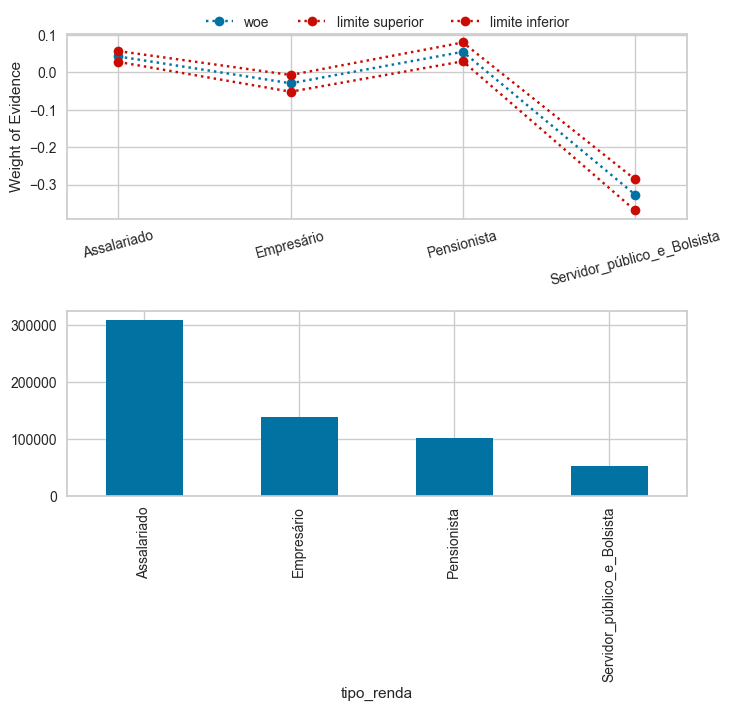

In [28]:
df.tipo_renda.replace({'Servidor público':'Servidor_público_e_Bolsista', 
                      'Bolsista':'Servidor_público_e_Bolsista',
                     }, inplace=True)

biv_discreta('tipo_renda', df);
IV(df.tipo_renda, df.mau)


Distribuição de educacao:



Médio                  405449
Superior completo      163440
Superior incompleto     23559
Fundamental              6901
Pós graduação             651
Name: educacao, dtype: int64

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,6420,481,0.069700,Fundamental,6901,0.003065,0.075709,0.063691,-2.591306,-2.502130,-2.687900,0.141385,0.230561,0.044791
Médio,379939,25510,0.062918,Médio,405449,0.000381,0.063665,0.062170,-2.700940,-2.688333,-2.713688,0.031751,0.044358,0.019003
Pós graduação,608,43,0.066052,Pós graduação,651,0.009735,0.085167,0.046937,-2.648975,-2.374126,-3.010867,0.083716,0.358565,-0.278176
Superior completo,154354,9086,0.055592,Superior completo,163440,0.000567,0.056703,0.054481,-2.832514,-2.811552,-2.853874,-0.099823,-0.078861,-0.121183
Superior incompleto,22036,1523,0.064646,Superior incompleto,23559,0.001602,0.067786,0.061506,-2.671995,-2.621201,-2.725141,0.060696,0.111490,0.007550


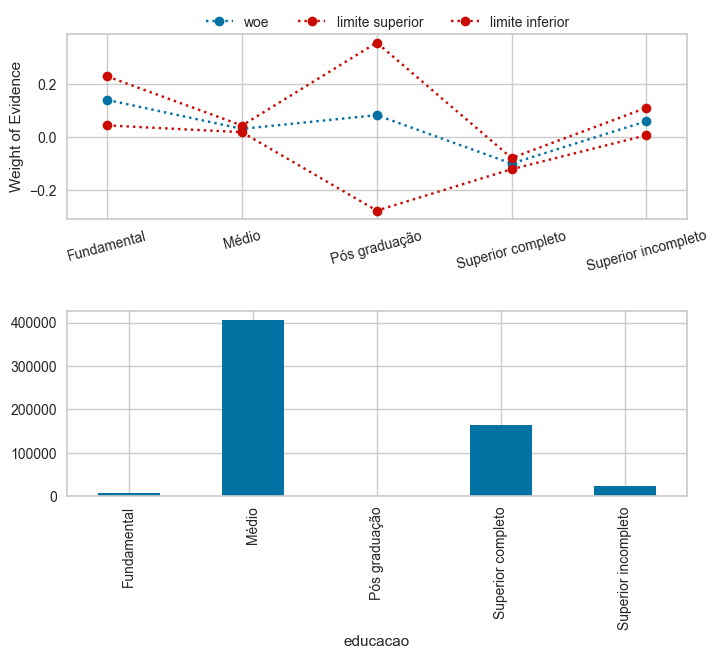

In [29]:
biv_discreta('educacao', df);


Distribuição de educacao:



Fundamental/Médio                    412350
Superior_Completo_e_Pós_graduação    164091
Superior incompleto                   23559
Name: educacao, dtype: int64

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental/Médio,386359,25991,0.063031,Fundamental/Médio,412350,0.000378,0.063773,0.062290,-2.699017,-2.686525,-2.711646,0.033674,0.046166,0.021045
Superior incompleto,22036,1523,0.064646,Superior incompleto,23559,0.001602,0.067786,0.061506,-2.671995,-2.621201,-2.725141,0.060696,0.111490,0.007550
Superior_Completo_e_Pós_graduação,154962,9129,0.055634,Superior_Completo_e_Pós_graduação,164091,0.000566,0.056743,0.054525,-2.831724,-2.810810,-2.853034,-0.099033,-0.078119,-0.120342


Fundamental/Médio                    412350
Superior_Completo_e_Pós_graduação    164091
Superior incompleto                   23559
Name: educacao, dtype: int64


0.0035079490810605825

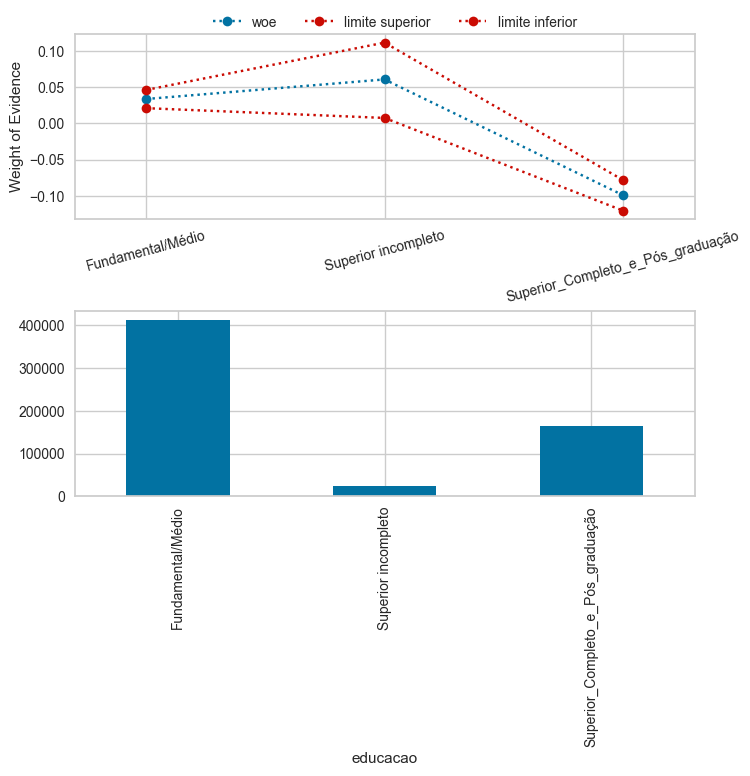

In [30]:
df.educacao.replace({'Fundamental':'Fundamental/Médio', 
                      'Médio':'Fundamental/Médio', 
                    'Superior completo' : 'Superior_Completo_e_Pós_graduação',
                    'Pós graduação':'Superior_Completo_e_Pós_graduação'
                     }, inplace=True)

biv_discreta('educacao', df);
print(df.educacao.value_counts())
IV(df.educacao, df.mau)


Distribuição de estado_civil:



Casado      421149
Solteiro     73221
União        46108
Separado     34188
Viúvo        25334
Name: estado_civil, dtype: int64

,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,395880,25269,0.060000,Casado,421149,0.000366,0.060717,0.059283,-2.751533,-2.738886,-2.764322,-0.018842,-0.006195,-0.031631
Separado,31994,2194,0.064175,Separado,34188,0.001325,0.066772,0.061577,-2.679822,-2.637360,-2.723916,0.052869,0.095331,0.008775
Solteiro,68585,4636,0.063315,Solteiro,73221,0.000900,0.065079,0.061551,-2.694222,-2.664858,-2.724359,0.038469,0.067833,0.008332
União,43048,3060,0.066366,União,46108,0.001159,0.068638,0.064094,-2.643901,-2.607801,-2.681168,0.088790,0.124890,0.051523
Viúvo,23850,1484,0.058577,Viúvo,25334,0.001475,0.061469,0.055686,-2.777043,-2.725779,-2.830738,-0.044352,0.006912,-0.098047


,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,395880,25269,0.060000,Casado,421149,0.000366,0.060717,0.059283,-2.751533,-2.738886,-2.764322,-0.018842,-0.006195,-0.031631
Separado,31994,2194,0.064175,Separado,34188,0.001325,0.066772,0.061577,-2.679822,-2.637360,-2.723916,0.052869,0.095331,0.008775
Solteiro,68585,4636,0.063315,Solteiro,73221,0.000900,0.065079,0.061551,-2.694222,-2.664858,-2.724359,0.038469,0.067833,0.008332
União,43048,3060,0.066366,União,46108,0.001159,0.068638,0.064094,-2.643901,-2.607801,-2.681168,0.088790,0.124890,0.051523
Viúvo,23850,1484,0.058577,Viúvo,25334,0.001475,0.061469,0.055686,-2.777043,-2.725779,-2.830738,-0.044352,0.006912,-0.098047


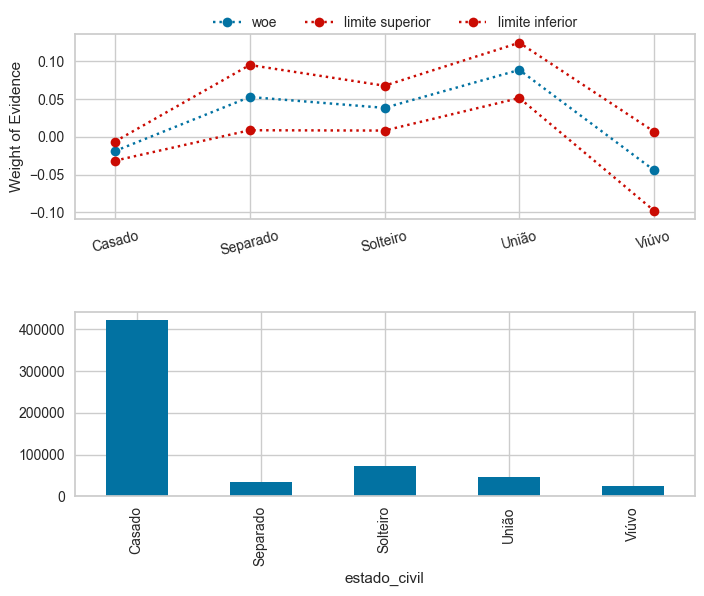

In [31]:
biv_discreta('estado_civil', df)


Distribuição de tipo_residencia:



Casa             539336
Com os pais       26730
Governamental     18742
Aluguel            8262
Estúdio            4296
Comunitário        2634
Name: tipo_residencia, dtype: int64

,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,7666,596,0.072137,Aluguel,8262,0.002846,0.077717,0.066558,-2.554310,-2.473779,-2.640804,0.178382,0.258912,0.091887
Casa,506887,32449,0.060165,Casa,539336,0.000324,0.060799,0.059530,-2.748618,-2.737450,-2.759898,-0.015927,-0.004759,-0.027207
Com os pais,24733,1997,0.074710,Com os pais,26730,0.001608,0.077862,0.071558,-2.516492,-2.471755,-2.563000,0.216199,0.260936,0.169691
Comunitário,2449,185,0.070235,Comunitário,2634,0.004979,0.079999,0.060472,-2.583079,-2.442363,-2.743199,0.149612,0.290329,-0.010508
Estúdio,4071,225,0.052374,Estúdio,4296,0.003399,0.059038,0.045711,-2.895544,-2.768721,-3.038637,-0.162852,-0.036030,-0.305946
Governamental,17551,1191,0.063547,Governamental,18742,0.001782,0.067040,0.060054,-2.690318,-2.633076,-2.750571,0.042373,0.099615,-0.017880


,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,7666,596,0.072137,Aluguel,8262,0.002846,0.077717,0.066558,-2.554310,-2.473779,-2.640804,0.178382,0.258912,0.091887
Casa,506887,32449,0.060165,Casa,539336,0.000324,0.060799,0.059530,-2.748618,-2.737450,-2.759898,-0.015927,-0.004759,-0.027207
Com os pais,24733,1997,0.074710,Com os pais,26730,0.001608,0.077862,0.071558,-2.516492,-2.471755,-2.563000,0.216199,0.260936,0.169691
Comunitário,2449,185,0.070235,Comunitário,2634,0.004979,0.079999,0.060472,-2.583079,-2.442363,-2.743199,0.149612,0.290329,-0.010508
Estúdio,4071,225,0.052374,Estúdio,4296,0.003399,0.059038,0.045711,-2.895544,-2.768721,-3.038637,-0.162852,-0.036030,-0.305946
Governamental,17551,1191,0.063547,Governamental,18742,0.001782,0.067040,0.060054,-2.690318,-2.633076,-2.750571,0.042373,0.099615,-0.017880


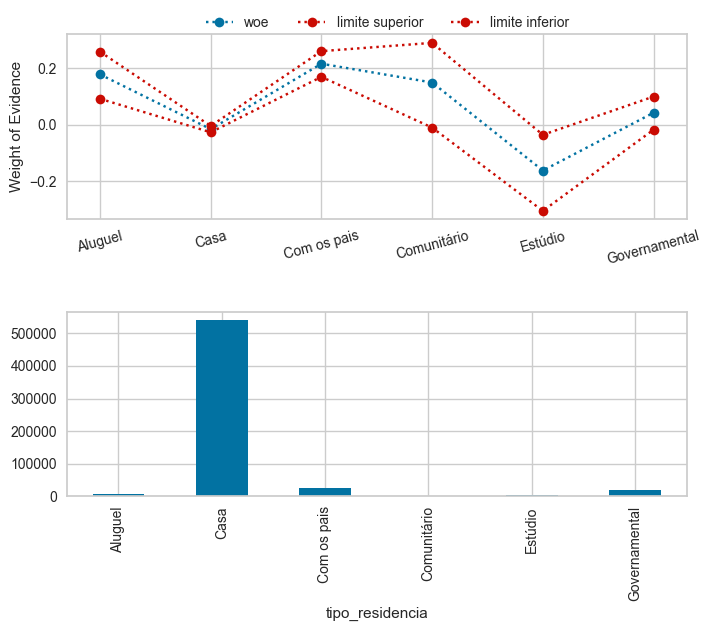

In [32]:
biv_discreta('tipo_residencia', df)


Distribuição de idade:



40    19662
37    19102
39    18555
32    17754
33    17564
41    17464
28    17406
43    17401
34    17339
38    17294
27    17289
42    17251
30    16838
46    16357
31    15995
35    15945
36    15805
54    15648
45    15645
47    15525
50    15519
51    15351
44    15283
48    15179
60    14689
29    14202
59    13074
58    12978
57    12836
53    12818
52    12685
49    12089
56    11916
55    10671
62    10420
63     9172
61     8830
64     8712
26     7085
25     5493
65     5442
66     4954
24     3978
67     2585
23     1132
68      669
22      399
Name: idade, dtype: int64

,qt_bom,qt_mau,mau,idade,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
idade,,,,,,,,,,,,,,
"(21.0, 33.0]",125124,10011,0.074081,29.352684,135135,0.000712,0.075478,0.072685,-2.525621,-2.505437,-2.546157,0.207070,0.227254,0.186534
"(33.0, 40.0]",115999,7703,0.062271,37.110572,123702,0.000687,0.063617,0.060924,-2.711972,-2.689140,-2.735269,0.020719,0.043551,-0.002578
"(40.0, 47.0]",108456,6470,0.056297,43.918548,114926,0.000680,0.057630,0.054964,-2.819168,-2.794360,-2.844535,-0.086477,-0.061669,-0.111844
"(47.0, 55.0]",104348,5612,0.051037,51.388459,109960,0.000664,0.052338,0.049736,-2.922824,-2.896285,-2.950012,-0.190133,-0.163594,-0.217320
"(55.0, 68.0]",109430,6847,0.058885,60.406039,116277,0.000690,0.060238,0.057532,-2.771474,-2.747317,-2.796158,-0.038783,-0.014626,-0.063467


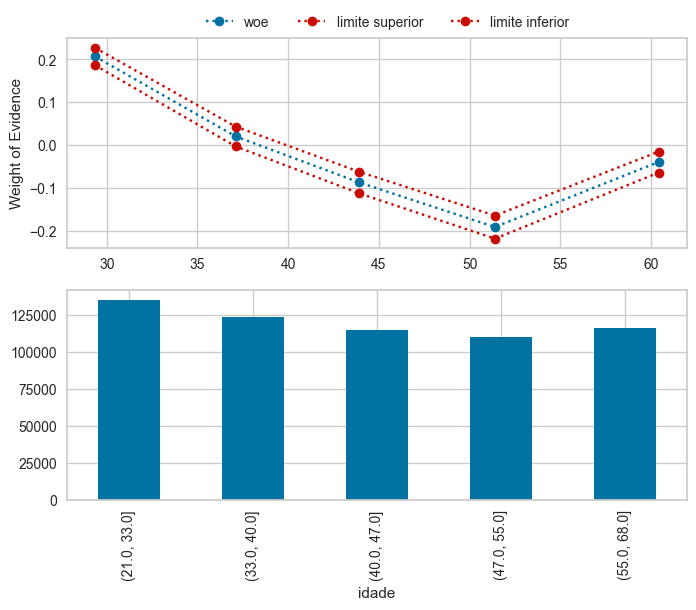

In [33]:
biv_continua('idade', 5, df)


Distribuição de tempo_emprego:



7.747992     100875
4.216438       1470
4.797260       1072
5.216438       1048
6.934247       1017
              ...  
0.786301         22
5.347945         22
8.887671         22
25.189041        20
38.704110        20
Name: tempo_emprego, Length: 3005, dtype: int64

,qt_bom,qt_mau,mau,tempo_emprego,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tempo_emprego,,,,,,,,,,,,,,
"(-1.0, 3.0]",108015,12013,0.100085,1.480954,120028,0.000866,0.101783,0.098387,-2.196281,-2.177571,-2.215275,0.536410,0.555121,0.517416
"(3.0, 6.0]",110844,9130,0.076100,4.314712,119974,0.000766,0.077600,0.074599,-2.496558,-2.475408,-2.518094,0.236133,0.257283,0.214597
"(6.0, 8.0]",159447,10150,0.059848,7.337646,169597,0.000576,0.060977,0.058719,-2.754238,-2.734349,-2.774481,-0.021547,-0.001658,-0.041790
"(8.0, 10.0]",67297,3169,0.044972,8.972331,70466,0.000781,0.046502,0.043442,-3.055700,-3.020637,-3.091918,-0.323008,-0.287946,-0.359227
"(10.0, 43.0]",117754,2181,0.018185,17.315205,119935,0.000386,0.018941,0.017429,-3.988814,-3.947300,-4.032059,-1.256123,-1.214609,-1.299368


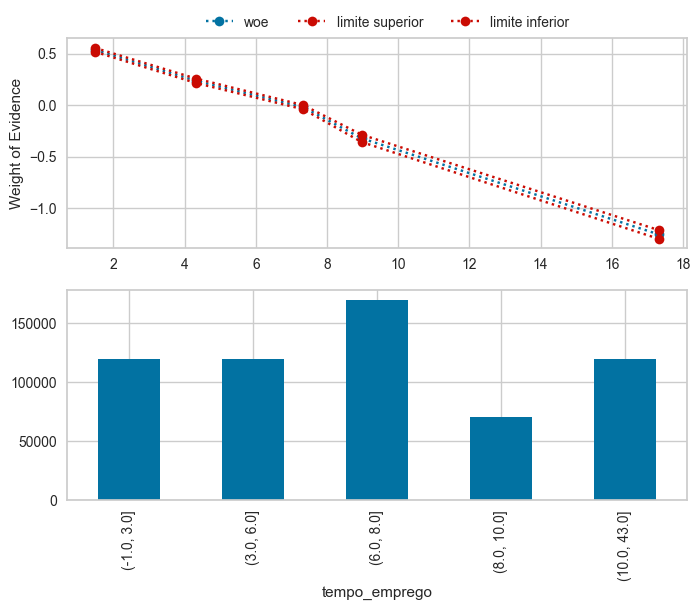

In [34]:
biv_continua('tempo_emprego', 5, df)


Distribuição de qt_pessoas_residencia:



2.0     326181
1.0     108657
3.0     104126
4.0      53314
5.0       6638
6.0        890
9.0         82
15.0        71
7.0         41
Name: qt_pessoas_residencia, dtype: int64

,qt_bom,qt_mau,mau,qt_pessoas_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qt_pessoas_residencia,,,,,,,,,,,,,,
1.0,101834,6823,0.062794,1.0,108657,0.000736,0.064236,0.061351,-2.703045,-2.678793,-2.727822,0.029646,0.053898,0.004869
2.0,306954,19227,0.058946,2.0,326181,0.000412,0.059754,0.058138,-2.770382,-2.755904,-2.785048,-0.037691,-0.023213,-0.052357
3.0,97323,6803,0.065334,3.0,104126,0.000766,0.066835,0.063833,-2.660672,-2.636351,-2.685518,0.072019,0.096340,0.047173
4.0,50051,3263,0.061203,4.0,53314,0.001038,0.063238,0.059169,-2.730395,-2.695521,-2.766371,0.002296,0.037170,-0.033680
5.0,6189,449,0.067641,5.0,6638,0.003082,0.073683,0.061599,-2.623506,-2.531442,-2.723540,0.109185,0.201250,0.009151
6.0,832,58,0.065169,6.0,890,0.008274,0.081406,0.048931,-2.663389,-2.423389,-2.967184,0.069302,0.309302,-0.234493
7.0,41,0,0.000000,7.0,41,0.000000,0.000000,0.000000,-inf,-inf,-inf,-inf,-inf,-inf
9.0,69,13,0.158537,9.0,82,0.040334,0.238789,0.078284,-1.669157,-1.159328,-2.465897,1.063534,1.573363,0.266795
15.0,64,7,0.098592,15.0,71,0.035379,0.169154,0.028029,-2.212973,-1.591637,-3.546072,0.519718,1.141054,-0.813381


,qt_bom,qt_mau,mau,qt_pessoas_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qt_pessoas_residencia,,,,,,,,,,,,,,
1.0,101834,6823,0.062794,1.0,108657,0.000736,0.064236,0.061351,-2.703045,-2.678793,-2.727822,0.029646,0.053898,0.004869
2.0,306954,19227,0.058946,2.0,326181,0.000412,0.059754,0.058138,-2.770382,-2.755904,-2.785048,-0.037691,-0.023213,-0.052357
3.0,97323,6803,0.065334,3.0,104126,0.000766,0.066835,0.063833,-2.660672,-2.636351,-2.685518,0.072019,0.096340,0.047173
4.0,50051,3263,0.061203,4.0,53314,0.001038,0.063238,0.059169,-2.730395,-2.695521,-2.766371,0.002296,0.037170,-0.033680
5.0,6189,449,0.067641,5.0,6638,0.003082,0.073683,0.061599,-2.623506,-2.531442,-2.723540,0.109185,0.201250,0.009151
6.0,832,58,0.065169,6.0,890,0.008274,0.081406,0.048931,-2.663389,-2.423389,-2.967184,0.069302,0.309302,-0.234493
7.0,41,0,0.000000,7.0,41,0.000000,0.000000,0.000000,-inf,-inf,-inf,-inf,-inf,-inf
9.0,69,13,0.158537,9.0,82,0.040334,0.238789,0.078284,-1.669157,-1.159328,-2.465897,1.063534,1.573363,0.266795
15.0,64,7,0.098592,15.0,71,0.035379,0.169154,0.028029,-2.212973,-1.591637,-3.546072,0.519718,1.141054,-0.813381


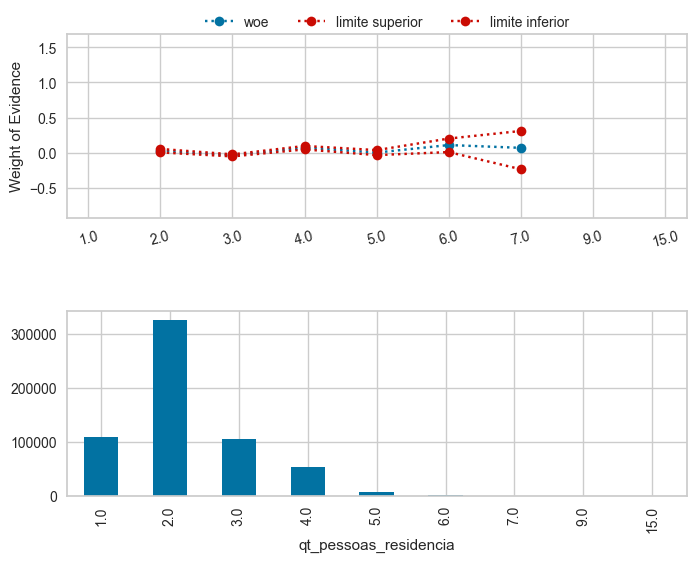

In [35]:
biv_discreta('qt_pessoas_residencia', df)


Distribuição de renda:



1926.67     27
13317.81    26
3564.05     25
3406.49     25
7446.88     24
            ..
8962.34      1
14138.40     1
51272.69     1
29760.89     1
3541.00      1
Name: renda, Length: 112472, dtype: int64

,qt_bom,qt_mau,mau,renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
renda,,,,,,,,,,,,,,
"(161.0, 3905.0]",100204,19799,0.164988,2399.865216,120003,0.001071,0.167088,0.162887,-1.621577,-1.606410,-1.636899,1.111114,1.126281,1.095792
"(3905.0, 7431.0]",111685,8313,0.069276,5558.329421,119998,0.000733,0.070713,0.067839,-2.597862,-2.575790,-2.620361,0.134829,0.156901,0.112330
"(7431.0, 13152.0]",115137,4867,0.040557,10026.531711,120004,0.000569,0.041673,0.039441,-3.163645,-3.135334,-3.192712,-0.430954,-0.402643,-0.460021
"(13152.0, 26667.0]",117316,2684,0.022367,18646.029095,120000,0.000427,0.023203,0.021530,-3.777563,-3.739983,-3.816543,-1.044872,-1.007292,-1.083852
"(26667.0, 4083986.0]",119015,980,0.008167,99487.311946,119995,0.000260,0.008676,0.007658,-4.799452,-4.738452,-4.864347,-2.066761,-2.005761,-2.131656


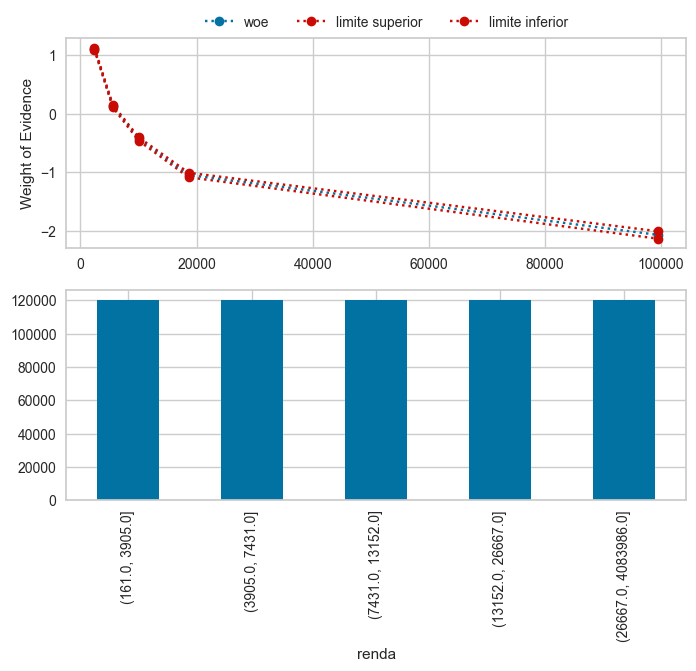

In [36]:
biv_continua('renda', 5, df);

In [37]:
' + '.join(df.columns)

'sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia + renda + mau + bom'

In [38]:
formula = '''
        mau ~ posse_de_veiculo + posse_de_imovel + qtd_filhos
        + tipo_renda + educacao + estado_civil + tipo_residencia
        + idade + tempo_emprego + qt_pessoas_residencia + renda
'''
rl = smf.glm(formula, data=df, family=sm.families.Binomial()).fit()

rl.summary().tables[0]

Dep. Variable:,mau,No. Observations:,600000
Model:,GLM,Df Residuals:,599978
Model Family:,Binomial,Df Model:,21
Link Function:,Logit,Scale:,1.0000
Method:,IRLS,Log-Likelihood:,-1.2493e+05
Date:,"Thu, 19 Sep 2024",Deviance:,2.4974e+05
Time:,22:42:19,Pearson chi2:,1.66e+16
No. Iterations:,11,Pseudo R-squ. (CS):,0.04245
Covariance Type:,nonrobust,,


In [39]:
tabela = pd.read_html(rl.summary().tables[1].as_html(), header=0, index_col=0)[0]
tabela.style.format(decimal=',', precision=4)\
    .highlight_between(
        left=.05
        , axis=1
        , props='color:red'
        , subset='P>|z|'
    ).set_properties(**{'background-color': '#ffffb3'}, subset=['[0.025', '0.975]'])

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,"-1,4961","0,0800","-18,5950","0,0000","-1,6540","-1,3380"
posse_de_veiculo[T.S],"-0,0077","0,0120","-0,6570","0,5110","-0,0310","0,0150"
posse_de_imovel[T.S],"-0,0806","0,0120","-6,8320","0,0000","-0,1040","-0,0570"
tipo_renda[T.Empresário],"-0,0461","0,0140","-3,2990","0,0010","-0,0740","-0,0190"
tipo_renda[T.Pensionista],"-0,0307","0,0200","-1,5180","0,1290","-0,0700","0,0090"
tipo_renda[T.Servidor_público_e_Bolsista],"-0,0268","0,0230","-1,1540","0,2480","-0,0720","0,0190"
educacao[T.Superior incompleto],"-0,0451","0,0280","-1,5940","0,1110","-0,1010","0,0100"
educacao[T.Superior_Completo_e_Pós_graduação],"-0,0506","0,0130","-3,8350","0,0000","-0,0770","-0,0250"
estado_civil[T.Separado],"0,0540","0,0380","1,4170","0,1560","-0,0210","0,1290"
estado_civil[T.Solteiro],"0,0172","0,0350","0,4910","0,6230","-0,0520","0,0860"


Analisando o valor de P>|z|, iremos remover as variáveis que tiverem valores superiores a 0,05. Para isso, será necessário transformar algumas variáveis categóricas em dummies, ficando assim o data frame:

In [40]:
df_dummies = pd.get_dummies(df, columns=['tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'],
                                  drop_first=True)
df_dummies.head(2)

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,bom,...,educacao_Superior_Completo_e_Pós_graduação,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,F,N,N,0,43,6.873973,1.0,2515.39,0,1,...,0,0,1,0,0,1,0,0,0,0
1,F,S,S,0,35,4.526027,2.0,3180.19,0,1,...,0,0,0,0,0,1,0,0,0,0


In [41]:
%%time
formula = '''
        mau ~ tipo_renda_Empresário
        + educacao_Superior_Completo_e_Pós_graduação
        + estado_civil_União + tipo_residencia_Casa
        + sexo + posse_de_veiculo + posse_de_imovel 
        + tempo_emprego + renda  
'''
rl1 = smf.glm(formula, data=df_dummies, family=sm.families.Binomial()).fit()

rl1.summary().tables[0]

CPU times: total: 5.3 s
Wall time: 8.88 s


Dep. Variable:,mau,No. Observations:,600000
Model:,GLM,Df Residuals:,599990
Model Family:,Binomial,Df Model:,9
Link Function:,Logit,Scale:,1.0000
Method:,IRLS,Log-Likelihood:,-1.2489e+05
Date:,"Thu, 19 Sep 2024",Deviance:,2.4967e+05
Time:,22:42:29,Pearson chi2:,1.58e+16
No. Iterations:,11,Pseudo R-squ. (CS):,0.04257
Covariance Type:,nonrobust,,


In [42]:
tabela = pd.read_html(rl1.summary().tables[1].as_html(), header=0, index_col=0)[0]
tabela.style.format(decimal=',', precision=4)\
    .highlight_between(
        left=.05
        , axis=1
        , props='color:red'
        , subset='P>|z|'
    ).set_properties(**{'background-color': '#ffffb3'}, subset=['[0.025', '0.975]'])

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,"-1,4758","0,0200","-72,7470","0,0000","-1,5160","-1,4360"
sexo[T.M],"-0,1198","0,0130","-9,2900","0,0000","-0,1450","-0,0950"
posse_de_veiculo[T.S],"0,0323","0,0120","2,6520","0,0080","0,0080","0,0560"
posse_de_imovel[T.S],"-0,0864","0,0120","-7,3890","0,0000","-0,1090","-0,0630"
tipo_renda_Empresário,"-0,0435","0,0130","-3,2440","0,0010","-0,0700","-0,0170"
educacao_Superior_Completo_e_Pós_graduação,"-0,0565","0,0130","-4,3950","0,0000","-0,0820","-0,0310"
estado_civil_União,"0,0466","0,0200","2,3340","0,0200","0,0070","0,0860"
tipo_residencia_Casa,"-0,0234","0,0180","-1,3140","0,1890","-0,0580","0,0110"
tempo_emprego,"-0,0250","0,0020","-14,6630","0,0000","-0,0280","-0,0220"
renda,"-0,0001","0,0000","-93,9260","0,0000","-0,0000","-0,0001"


In [43]:
%%time
formula = '''
        mau ~ tipo_renda_Empresário
        + educacao_Superior_Completo_e_Pós_graduação
        + estado_civil_União + sexo + posse_de_veiculo
        + posse_de_imovel + tempo_emprego + renda  
'''
rl2 = smf.glm(formula, data=df_dummies, family=sm.families.Binomial()).fit()

rl2.summary().tables[0]

CPU times: total: 5.09 s
Wall time: 8.53 s


Dep. Variable:,mau,No. Observations:,600000
Model:,GLM,Df Residuals:,599991
Model Family:,Binomial,Df Model:,8
Link Function:,Logit,Scale:,1.0000
Method:,IRLS,Log-Likelihood:,-1.2489e+05
Date:,"Thu, 19 Sep 2024",Deviance:,2.4967e+05
Time:,22:42:37,Pearson chi2:,1.58e+16
No. Iterations:,11,Pseudo R-squ. (CS):,0.04257
Covariance Type:,nonrobust,,


In [44]:
tabela = pd.read_html(rl2.summary().tables[1].as_html(), header=0, index_col=0)[0]
tabela.style.format(decimal=',', precision=4)\
    .highlight_between(
        left=.05
        , axis=1
        , props='color:red'
        , subset='P>|z|'
    ).set_properties(**{'background-color': '#ffffb3'}, subset=['[0.025', '0.975]'])

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,"-1,4940","0,0150","-100,5810","0,0000","-1,5230","-1,4650"
sexo[T.M],"-0,1191","0,0130","-9,2450","0,0000","-0,1440","-0,0940"
posse_de_veiculo[T.S],"0,0323","0,0120","2,6500","0,0080","0,0080","0,0560"
posse_de_imovel[T.S],"-0,0895","0,0110","-7,8230","0,0000","-0,1120","-0,0670"
tipo_renda_Empresário,"-0,0437","0,0130","-3,2600","0,0010","-0,0700","-0,0170"
educacao_Superior_Completo_e_Pós_graduação,"-0,0563","0,0130","-4,3800","0,0000","-0,0810","-0,0310"
estado_civil_União,"0,0465","0,0200","2,3290","0,0200","0,0070","0,0860"
tempo_emprego,"-0,0251","0,0020","-14,7890","0,0000","-0,0280","-0,0220"
renda,"-0,0001","0,0000","-93,9200","0,0000","-0,0000","-0,0001"


## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [45]:
# Base de treino
df_dummies['score'] = rl2.predict(df_dummies)
acuracia_train = metrics.accuracy_score(df_dummies.mau, df_dummies.score>.068)
fpr, tpr, thresholds = metrics.roc_curve(df_dummies.mau, df_dummies.score)
auc_train = metrics.auc(fpr, tpr)
gini_train = 2* auc_train - 1
ks_train = ks_2samp(df_dummies.loc[df_dummies.mau == 1, 'score'],
              df_dummies.loc[df_dummies.mau != 1, 'score']).statistic
print(f'BASE DE TREINO\nAcurácia: {acuracia_train:.2f}\nKS: {ks_train:.2f}\nGini: {gini_train:.2f}\nAUC: {auc_train:.2f}')

BASE DE TREINO
Acurácia: 0.59
KS: 0.39
Gini: 0.53
AUC: 0.77


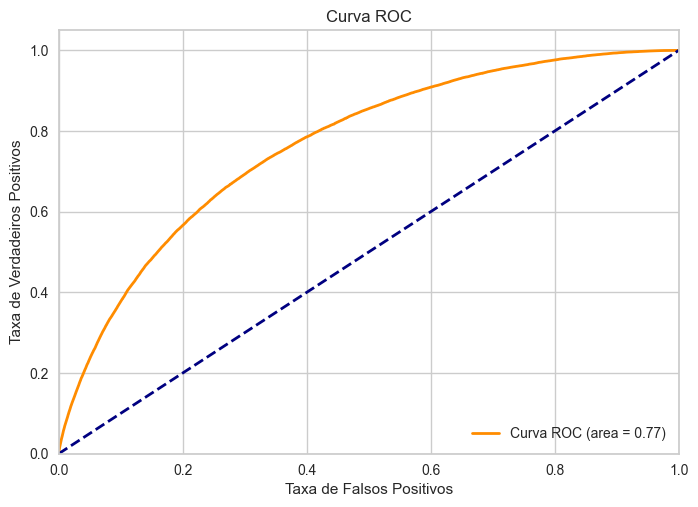

In [46]:
# Gráfico curva ROC
fpr, tpr, thresholds = metrics.roc_curve(df_dummies['mau'], df_dummies['score'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(df_dummies['mau'], df_dummies['score'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Curva ROC (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [47]:
# Passando os mesmos tratamentos feitos nas variaveis para a base de teste e out of time
media_tempo_emprego = df_test['tempo_emprego'].mean()
df_test['tempo_emprego'] = df_test['tempo_emprego'].fillna(media_tempo_emprego)

df_test.qtd_filhos.replace({4:3, 5:3, 7:3, 14:3}, inplace=True)
df_test.educacao.replace({'Fundamental':'Fundamental/Médio', 
                      'Médio':'Fundamental/Médio', 
                    'Superior completo' : 'Superior_Completo_e_Pós_graduação',
                    'Pós graduação':'Superior_Completo_e_Pós_graduação'
                     }, inplace=True)
df_test.tipo_renda.replace({'Servidor público':'Servidor_público_e_Bolsista', 
                      'Bolsista':'Servidor_público_e_Bolsista',
                     }, inplace=True)
df_test_dummies = pd.get_dummies(df_test, columns=['tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'],
                                  drop_first=True)
df_test_dummies.head(2)

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,tipo_renda_Empresário,...,educacao_Superior_Completo_e_Pós_graduação,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
600000,F,S,S,2,38,7.383562,4.0,2969.49,1,0,...,1,0,0,0,0,1,0,0,0,0
600001,F,N,S,0,55,8.471233,2.0,6278.37,0,0,...,0,0,0,0,0,1,0,0,0,0


In [48]:
%%time
formula = '''
        mau ~ tipo_renda_Empresário
        + educacao_Superior_Completo_e_Pós_graduação
        + estado_civil_União + sexo + posse_de_veiculo
        + posse_de_imovel + tempo_emprego + renda  
'''
rl_test = smf.glm(formula, data=df_test_dummies, family=sm.families.Binomial()).fit()

tabela = pd.read_html(rl_test.summary().tables[1].as_html(), header=0, index_col=0)[0]
tabela.style.format(decimal=',', precision=4)\
    .highlight_between(
        left=.05
        , axis=1
        , props='color:red'
        , subset='P>|z|'
    ).set_properties(**{'background-color': '#ffffb3'}, subset=['[0.025', '0.975]'])

CPU times: total: 1.08 s
Wall time: 2.06 s


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,"-0,6223","0,0210","-30,2830","0,0000","-0,6630","-0,5820"
sexo[T.M],"-0,1277","0,0180","-7,2870","0,0000","-0,1620","-0,0930"
posse_de_veiculo[T.S],"0,0095","0,0170","0,5680","0,5700","-0,0230","0,0420"
posse_de_imovel[T.S],"-0,1142","0,0160","-7,2480","0,0000","-0,1450","-0,0830"
tipo_renda_Empresário,"-0,0357","0,0180","-1,9500","0,0510","-0,0720","0,0000"
educacao_Superior_Completo_e_Pós_graduação,"-0,0594","0,0180","-3,3940","0,0010","-0,0940","-0,0250"
estado_civil_União,"-0,0040","0,0280","-0,1440","0,8850","-0,0580","0,0500"
tempo_emprego,"-0,0303","0,0020","-12,4870","0,0000","-0,0350","-0,0260"
renda,"-0,0002","0,0000","-55,4620","0,0000","-0,0000","-0,0000"


In [49]:
# Base de teste
df_test_dummies['score'] = rl_test.predict(df_test_dummies)
acuracia_test = metrics.accuracy_score(df_test_dummies.mau, df_test_dummies.score>.068)
fpr, tpr, thresholds = metrics.roc_curve(df_test_dummies.mau, df_test_dummies.score)
auc_test = metrics.auc(fpr, tpr)
gini_test = 2* auc_test - 1
ks_test = ks_2samp(df_test_dummies.loc[df_test_dummies.mau == 1, 'score'],
              df_test_dummies.loc[df_test_dummies.mau != 1, 'score']).statistic
print(f'BASE DE TESTE\nAcurácia: {acuracia_test:.2f}\nKS: {ks_test:.2f}\nGini: {gini_test:.2f}\nAUC: {auc_test:.2f}')

BASE DE TESTE
Acurácia: 0.36
KS: 0.34
Gini: 0.47
AUC: 0.73


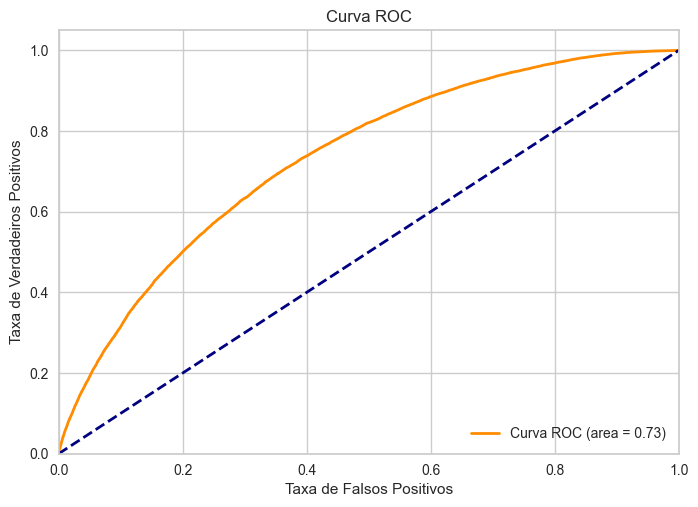

In [50]:
# Gráfico curva ROC
fpr, tpr, thresholds = metrics.roc_curve(df_test_dummies['mau'], df_test_dummies['score'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(df_test_dummies['mau'], df_test_dummies['score'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Curva ROC (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Resultados:

Houve uma grande queda na acurácia entre as bases de treino e teste, enquanto as demais métricas como KS, Gini e AUC tiveram quedas suaves. Confira os resultados abaixo:

| Métricas | Treino | Teste |
|:-|:-|:-|
| Acurácia | 0.59 | 0.36 |
| KS | 0.39 | 0.34 |
| Gini | 0.53 | 0.47 |
| AUC | 0.77 | 0.73 |


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [51]:
# Existe nulos na base?
df = df_original.copy()
df.isna().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [52]:
# Tipo dos dados nulos
df.tempo_emprego.dtype

dtype('float64')

In [53]:
# Média
df.tempo_emprego.mean()

7.748574052205179

In [54]:
# Valor mais frequente
df.tempo_emprego.mode()[0]

4.216438356164384

In [55]:
# Mediana
df['tempo_emprego'].median()

6.046575342465753

In [56]:
media_tempo_emprego = df['tempo_emprego'].mean()
df['tempo_emprego'] = df['tempo_emprego'].fillna(media_tempo_emprego)
df.isna().sum()

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64

Iremos realizar a susbstituição dos valores pela média, pois mantém a tendência central da variável.

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

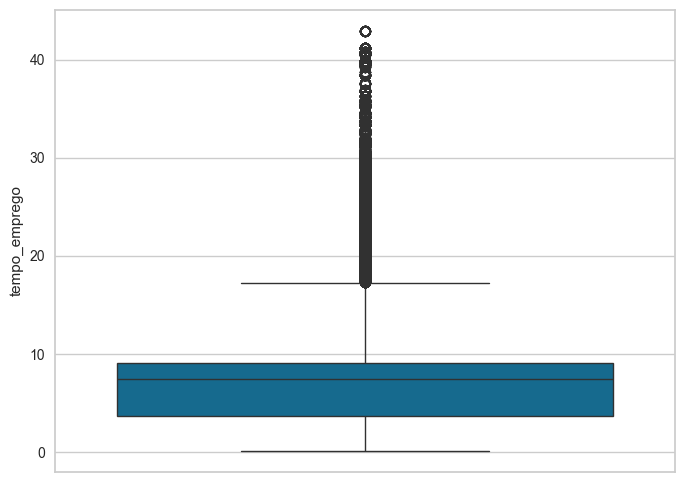

In [57]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=df.tempo_emprego)
plt.show()

In [58]:
def outliers_zscore(data, threshold=3):   
    z_scores = np.abs(stats.zscore(data))
    return (z_scores > threshold)

In [59]:
outliers_zscore(df['tempo_emprego']).value_counts()

False    733702
True      16298
Name: tempo_emprego, dtype: int64

In [60]:
%%time
outliers_mask = outliers_zscore(df['tempo_emprego'])
outliers = df[outliers_mask]

if not outliers.empty:
    print(f"Outliers na variável tempo_emprego:")
    print(outliers[['tempo_emprego']])

Outliers na variável tempo_emprego:
        tempo_emprego
220         36.865753
277         41.200000
345         27.654795
374         33.786301
381         30.117808
...               ...
749469      28.739726
749512      29.961644
749749      29.534247
749813      38.405479
749869      35.142466

[16298 rows x 1 columns]
CPU times: total: 0 ns
Wall time: 31 ms


In [61]:
outliers = df[outliers_mask]
outliers

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
220,2015-01-01,13235,M,N,S,0,Assalariado,Médio,Casado,Casa,56,36.865753,2.0,20430.45,0
277,2015-01-01,4272,F,S,S,0,Servidor público,Superior completo,Solteiro,Casa,60,41.200000,1.0,225869.93,0
345,2015-01-01,8554,F,N,S,1,Assalariado,Superior completo,Casado,Casa,50,27.654795,3.0,33563.18,0
374,2015-01-01,9376,F,N,N,0,Servidor público,Médio,Separado,Casa,53,33.786301,1.0,226413.24,0
381,2015-01-01,10760,F,N,N,0,Assalariado,Médio,Casado,Casa,51,30.117808,2.0,80524.67,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749469,2016-03-01,8109,F,N,S,1,Assalariado,Médio,Casado,Casa,54,28.739726,3.0,36253.97,0
749512,2016-03-01,294,F,N,N,0,Servidor público,Médio,Casado,Casa,51,29.961644,2.0,52048.96,0
749749,2016-03-01,7581,F,N,S,0,Assalariado,Médio,Casado,Casa,54,29.534247,2.0,125754.31,0
749813,2016-03-01,10382,F,N,S,0,Assalariado,Médio,Casado,Casa,57,38.405479,2.0,75421.01,0


In [62]:
outliers['tempo_emprego'].describe()

count    16298.000000
mean        31.234755
std          4.301642
min         26.049315
25%         27.698630
50%         30.117808
75%         33.282192
max         42.906849
Name: tempo_emprego, dtype: float64

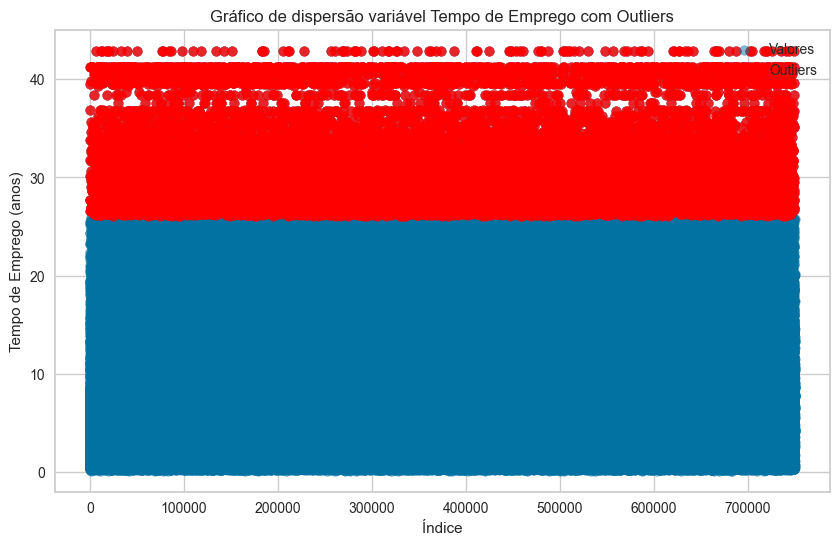

In [63]:
plt.figure(figsize=(10, 6))

plt.scatter(df.index, df['tempo_emprego'], label='Valores', alpha=0.5)
plt.scatter(outliers.index, outliers['tempo_emprego'], color='red', label='Outliers', alpha=0.8)
plt.title('Gráfico de dispersão variável Tempo de Emprego com Outliers')
plt.xlabel('Índice')
plt.ylabel('Tempo de Emprego (anos)')
plt.legend()
plt.show()

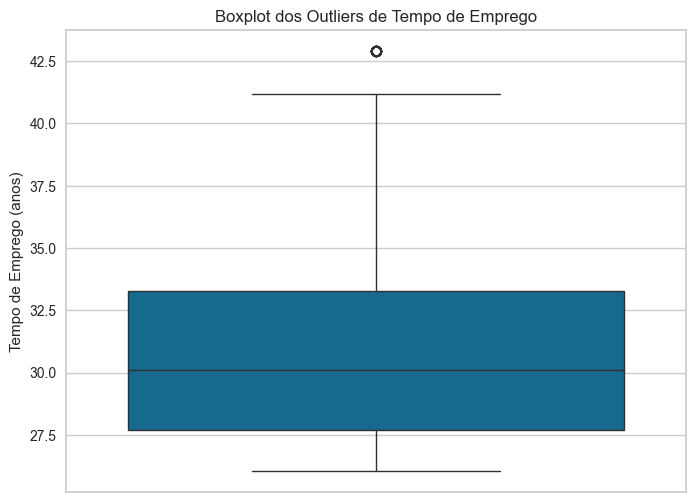

In [64]:
# Boxplot apenas de outliers
plt.figure(figsize=(8, 6))
sns.boxplot(y=outliers['tempo_emprego'])

# Título e rótulos
plt.title('Boxplot dos Outliers de Tempo de Emprego')
plt.ylabel('Tempo de Emprego (anos)')
plt.show()


Analisando os dados que foram classificados como outliers, não acredito que realmente sejam, pois são eventos que podem ocorrer na vida real, e eliminá-los distorceria demais o conjunto de dados.

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [65]:
# Todas variaveis 
df.columns

Index(['data_ref', 'index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau'],
      dtype='object')

In [66]:
# Função IV
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

# Populando o metadados
for var in metadados[metadados.papel == 'covariavel'].index:
    if pd.api.types.is_numeric_dtype(df[var]):
        if metadados.loc[var, 'unicos'] > 50:
            metadados.loc[var, 'IV'] = IV(pd.qcut(df[var], 5, duplicates='drop'), df.mau)
        else:
            metadados.loc[var, 'IV'] = IV(df[var], df.mau)
    else:
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)

In [67]:
metadados.loc[metadados['IV'] < 0.02, 'poder_preditivo'] = 'Irrelevante'
metadados.loc[(metadados['IV'] >= 0.02) & (metadados['IV'] <= 0.1), 'poder_preditivo'] = 'Fraco'
metadados.loc[(metadados['IV'] > 0.1) & (metadados['IV'] <= 0.3), 'poder_preditivo'] = 'Médio'
metadados.loc[(metadados['IV'] > 0.3) & (metadados['IV'] <= 0.5), 'poder_preditivo'] = 'Forte'
metadados.loc[metadados['IV'] > 0.5, 'poder_preditivo'] = 'Atenção, muito alto'
metadados

,dtype,nmissing,papel,unicos,IV,poder_preditivo
sexo,object,0,covariavel,2,0.002185,Irrelevante
posse_de_veiculo,object,0,covariavel,2,0.000108,Irrelevante
posse_de_imovel,object,0,covariavel,2,0.009693,Irrelevante
qtd_filhos,int64,0,covariavel,8,0.001631,Irrelevante
tipo_renda,object,0,covariavel,5,0.009360,Irrelevante
educacao,object,0,covariavel,5,0.003547,Irrelevante
estado_civil,object,0,covariavel,5,0.001126,Irrelevante
tipo_residencia,object,0,covariavel,6,0.003045,Irrelevante
idade,int64,0,covariavel,47,0.024717,Fraco
tempo_emprego,float64,0,covariavel,3005,0.278819,Médio


In [68]:
# Selecionar uma amostra de 75 mil linhas
df_amostra = df.sample(n=75000, random_state=42)
y_amostra = df_amostra['mau']
df_amostra = df_amostra.drop(['data_ref', 'mau', 'index'], axis=1)

X_amostra = pd.get_dummies(df_amostra, drop_first=True)

X_amostra.shape, y_amostra.shape

((75000, 25), (75000,))

In [69]:
%%time
# Boruta
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
boruta_selector = BorutaPy(rf, n_estimators='auto', random_state=42)
boruta_selector.fit(X_amostra.values, y_amostra.values)

boruta_selecao = X_amostra.columns[boruta_selector.support_].tolist()
print('Variáveis selecionadas pelo Boruta:')
print(boruta_selecao)

Variáveis selecionadas pelo Boruta:
['idade', 'tempo_emprego', 'renda']
CPU times: total: 25.1 s
Wall time: 44.3 s


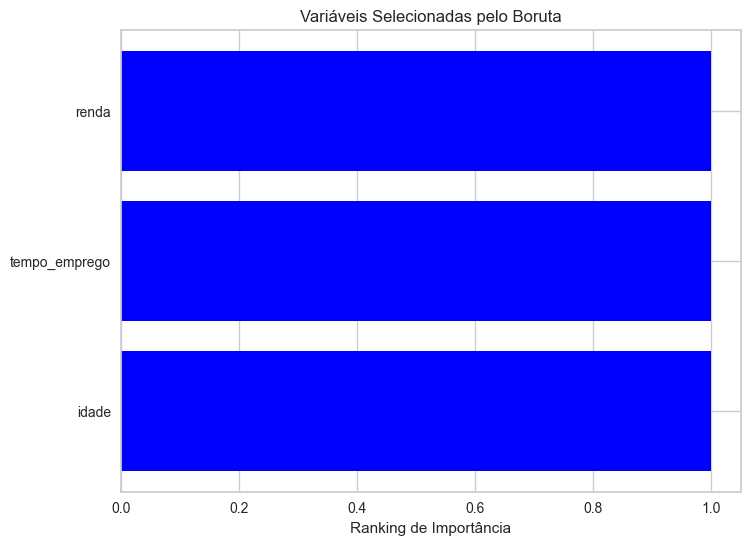

In [70]:
# Visualizar a importância das variáveis selecionadas pelo Boruta
variaveis_selecionadas_import = [boruta_selector.ranking_[X_amostra.columns.get_loc(selecao)] for selecao in boruta_selecao]

plt.figure(figsize=(8, 6))
plt.barh(boruta_selecao, variaveis_selecionadas_import, color='blue')
plt.xlabel('Ranking de Importância')
plt.title('Variáveis Selecionadas pelo Boruta')
plt.show()

Ranking das variáveis:
1. renda (0.6018)
2. tempo_emprego (0.1329)
3. idade (0.1179)
4. qt_pessoas_residencia (0.0181)
5. posse_de_veiculo_S (0.0163)
6. posse_de_imovel_S (0.0131)
7. sexo_M (0.0129)
8. qtd_filhos (0.0126)
9. tipo_renda_Empresário (0.0118)
10. estado_civil_União (0.0080)
11. educacao_Médio (0.0077)
12. educacao_Superior completo (0.0069)
13. estado_civil_Solteiro (0.0065)
14. tipo_residencia_Casa (0.0054)
15. tipo_renda_Servidor público (0.0053)
16. estado_civil_Separado (0.0049)
17. tipo_renda_Pensionista (0.0035)
18. educacao_Superior incompleto (0.0034)
19. tipo_residencia_Com os pais (0.0032)
20. tipo_residencia_Governamental (0.0029)
21. estado_civil_Viúvo (0.0029)
22. tipo_residencia_Estúdio (0.0010)
23. tipo_residencia_Comunitário (0.0006)
24. educacao_Pós graduação (0.0001)
25. tipo_renda_Bolsista (0.0001)


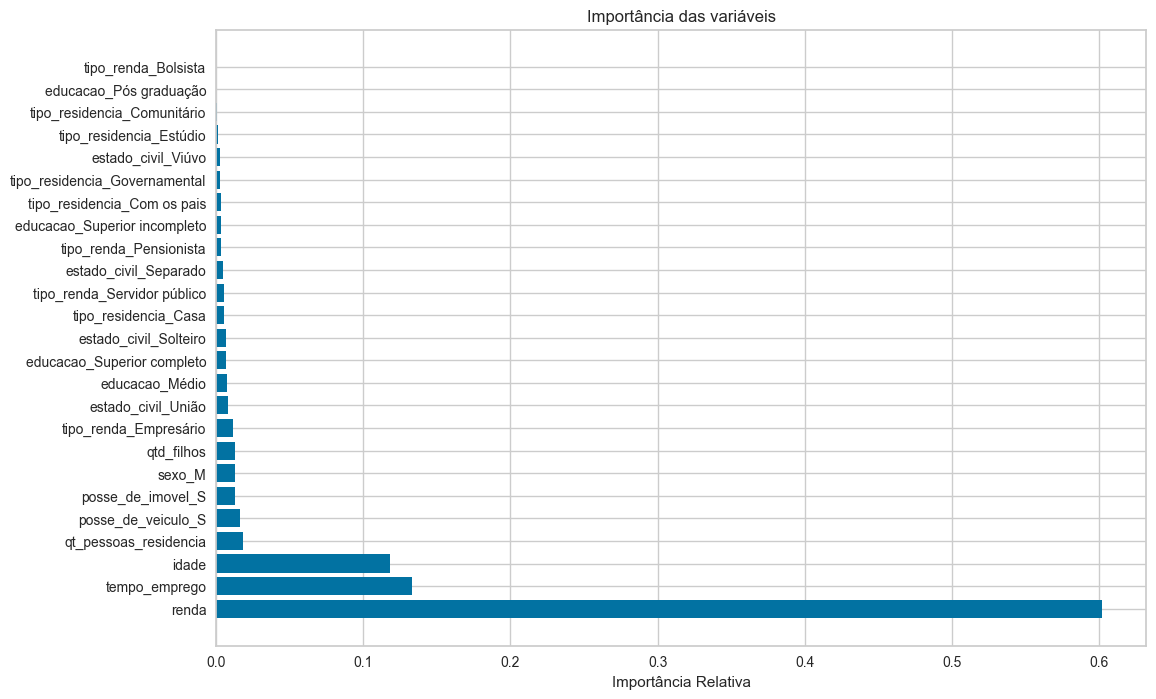

CPU times: total: 5.98 s
Wall time: 10 s


In [71]:
%%time
#Feature Importance
import matplotlib.pyplot as plt

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_amostra, y_amostra)

importancia = rf_model.feature_importances_

indices = importancia.argsort()[::-1]
variaveis_names = X_amostra.columns

print("Ranking das variáveis:")
for i in range(X_amostra.shape[1]):
    print(f"{i + 1}. {variaveis_names[indices[i]]} ({importancia[indices[i]]:.4f})")

plt.figure(figsize=(12, 8))
plt.title("Importância das variáveis")
plt.barh(range(X_amostra.shape[1]), importancia[indices], align='center')
plt.yticks(range(X_amostra.shape[1]), [variaveis_names[i] for i in indices])
plt.xlabel("Importância Relativa")
plt.show()


Utilizamos uma amostra reduzida de 75.000 linhas, 10% da base, de acordo com as técnicas Information Value (IV), Boruta e Feature Importance, obtivemos os seguintes insights:
- De acordo com IV, as variáveis apresentam poder preditivo fraco ou irrelevante, com exceção de ``tempo_enprego``, que possui poder médio. O IV também aponta que as variaveis ``renda`` e ``qt_pessoas_residencia`` têm poder preditivo muito alto, sugerindo um risco significativo de outliers.
- A técnica Boruta destaca ``renda``, ``tempo_enprego`` e ``idade`` como as mais importantes.
- No gráfico de Feature Importance, observamos importancia das mesmas variaveis identificadas pela Boruta.

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [72]:
df1 = df.copy()
df1.head(2)

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,0
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,0


In [73]:
df1 = df1.drop(['data_ref', 'index'], axis=1)

label_encoders = {}
for column in df1.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df1[column] = le.fit_transform(df1[column])
    label_encoders[column] = le

In [74]:
# Escalonar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df1)

In [75]:
# Aplicar PCA para reduzir a dimensionalidade para 5
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

print(f'Variância explicada pelos 5 componentes principais: {pca.explained_variance_ratio_}')
print(f'Variância total explicada: {sum(pca.explained_variance_ratio_)}')

Variância explicada pelos 5 componentes principais: [0.19863086 0.11895675 0.09770302 0.09064652 0.08306341]
Variância total explicada: 0.5890005633485891


In [76]:
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(5)])
df_pca

,PC1,PC2,PC3,PC4,PC5
0,-1.642538,-0.901531,-0.038275,1.188766,0.087718
1,0.397404,-0.550834,0.388070,-0.789049,-0.102285
2,2.774315,0.290835,-1.634559,1.489460,-0.269612
3,-0.942559,0.515155,0.144139,0.876512,-0.807742
4,-0.085700,-1.177424,1.856989,1.115144,2.540915
...,...,...,...,...,...
749995,-0.050774,-0.719438,0.133651,-1.031074,0.540582
749996,-2.784914,-0.333022,-1.002060,-0.559386,-0.315803
749997,3.215219,0.218272,0.004743,0.442501,-1.592474
749998,-2.510126,-1.017690,-0.751510,0.722216,0.297156


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [77]:
df2 = df.copy()
df2 = df2.drop(['data_ref', 'index'], axis=1)
df_dummies = pd.get_dummies(df2, columns=['sexo', 'posse_de_veiculo', 'posse_de_imovel',
                                         'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'],
                                  drop_first=False, prefix_sep='_')
df_dummies = df_dummies.astype(float)
df_dummies.head()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,sexo_F,sexo_M,posse_de_veiculo_N,posse_de_veiculo_S,...,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Aluguel,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,0.0,43.0,6.873973,1.0,2515.39,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,35.0,4.526027,2.0,3180.19,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2.0,31.0,0.243836,4.0,1582.29,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,54.0,12.772603,2.0,13721.17,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,31.0,8.432877,1.0,2891.08,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [78]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   qtd_filhos                     750000 non-null  float64
 1   idade                          750000 non-null  float64
 2   tempo_emprego                  750000 non-null  float64
 3   qt_pessoas_residencia          750000 non-null  float64
 4   renda                          750000 non-null  float64
 5   mau                            750000 non-null  float64
 6   sexo_F                         750000 non-null  float64
 7   sexo_M                         750000 non-null  float64
 8   posse_de_veiculo_N             750000 non-null  float64
 9   posse_de_veiculo_S             750000 non-null  float64
 10  posse_de_imovel_N              750000 non-null  float64
 11  posse_de_imovel_S              750000 non-null  float64
 12  tipo_renda_Assalariado        

In [79]:
variaveis = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']
for coluna in df_dummies:
    print(df_dummies[coluna].value_counts())
    print('\n')

0.0     517331
1.0     153021
2.0      69632
3.0       8669
4.0       1065
7.0        101
5.0         95
14.0        86
Name: qtd_filhos, dtype: int64


40.0    24663
37.0    23874
39.0    23309
32.0    22162
43.0    21871
41.0    21836
33.0    21834
38.0    21722
34.0    21720
28.0    21646
27.0    21599
42.0    21367
30.0    20926
46.0    20485
35.0    19970
31.0    19931
36.0    19786
45.0    19569
54.0    19517
50.0    19401
47.0    19346
51.0    19088
44.0    19068
48.0    18870
60.0    18275
29.0    17800
59.0    16348
58.0    16236
57.0    16172
53.0    16120
52.0    15835
49.0    15086
56.0    14883
55.0    13483
62.0    13085
63.0    11510
61.0    11090
64.0    10801
26.0     8891
25.0     6911
65.0     6792
66.0     6222
24.0     4949
67.0     3199
23.0     1402
68.0      855
22.0      495
Name: idade, dtype: int64


7.748574     125957
4.216438       1829
4.797260       1364
5.216438       1308
6.934247       1283
              ...  
13.939726        29
8.616438         28
8

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

**Obs:** Optei por realizar a criação das variáveis dummies antes do PCA, pelo fato de que essa técnica de redução de dimensionalidade só pode ser aplicada em dados numéricos.

In [80]:
df = df.drop(['data_ref', 'index'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sexo                   750000 non-null  object 
 1   posse_de_veiculo       750000 non-null  object 
 2   posse_de_imovel        750000 non-null  object 
 3   qtd_filhos             750000 non-null  int64  
 4   tipo_renda             750000 non-null  object 
 5   educacao               750000 non-null  object 
 6   estado_civil           750000 non-null  object 
 7   tipo_residencia        750000 non-null  object 
 8   idade                  750000 non-null  int64  
 9   tempo_emprego          750000 non-null  float64
 10  qt_pessoas_residencia  750000 non-null  float64
 11  renda                  750000 non-null  float64
 12  mau                    750000 non-null  int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 74.4+ MB


In [95]:
# Separar as variáveis independentese a variável resposta
X = df.drop(columns=['mau'])
y = df['mau']

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Variáveis categóricas e númericas
variaveis_cat = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']
variaveis_num = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

# Pipeline para as variáveis categóricas
transf_cat = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])


# Pipeline para as variáveis numéricas
transf_num = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())  
])


# Criação do pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transf_num, variaveis_num),
        ('cat', transf_cat, variaveis_cat)
    ])


# Construção do pipeline final com pré-processamento, PCA e modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=5)),
    ('classifier', LogisticRegression())
])


# Treinamento do pipeline
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

acuracia = accuracy_score(y_test, y_pred)
print(f'Acurácia: {acuracia:.4f}')

Acurácia: 0.9220


In [96]:
pipeline.named_steps

{'preprocessor': ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                   transformer_weights=None,
                   transformers=[('num',
                                  Pipeline(memory=None,
                                           steps=[('imputer',
                                                   SimpleImputer(add_indicator=False,
                                                                 copy=True,
                                                                 fill_value=None,
                                                                 keep_empty_features=False,
                                                                 missing_values=nan,
                                                                 strategy='mean',
                                                                 verbose='deprecated')),
                                                  ('scaler',
                                                   Stan

In [97]:
pipeline.steps

[('preprocessor',
  ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                    transformer_weights=None,
                    transformers=[('num',
                                   Pipeline(memory=None,
                                            steps=[('imputer',
                                                    SimpleImputer(add_indicator=False,
                                                                  copy=True,
                                                                  fill_value=None,
                                                                  keep_empty_features=False,
                                                                  missing_values=nan,
                                                                  strategy='mean',
                                                                  verbose='deprecated')),
                                                   ('scaler',
                                        

# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.

In [83]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['qtd_filhos', 'idade',
                                                   'tempo_emprego',
                                                   'qt_pessoas_residencia',
                                                   'renda']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['sexo', 'posse_de_veiculo',
                                                   'posse_de_imovel',
                                                   'tipo_renda', 'educacao',
                                                   'estado_civil',
                                                   'tipo_residencia'])])),
                ('pca', PCA(n_components=5)),
                ('classifier', LogisticRegression())])

In [84]:
type(pipeline)

sklearn.pipeline.Pipeline

In [89]:
data = df.sample(frac=0.95, random_state=786)
data_unseen = df.drop(data.index)

data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (712500, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (37500, 13)


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sexo                   750000 non-null  object 
 1   posse_de_veiculo       750000 non-null  object 
 2   posse_de_imovel        750000 non-null  object 
 3   qtd_filhos             750000 non-null  int64  
 4   tipo_renda             750000 non-null  object 
 5   educacao               750000 non-null  object 
 6   estado_civil           750000 non-null  object 
 7   tipo_residencia        750000 non-null  object 
 8   idade                  750000 non-null  int64  
 9   tempo_emprego          750000 non-null  float64
 10  qt_pessoas_residencia  750000 non-null  float64
 11  renda                  750000 non-null  float64
 12  mau                    750000 non-null  int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 74.4+ MB


In [103]:
%%time
# Configurar o ambiente PyCaret
clf = setup(data=df, target='mau', 
            categorical_features=['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'], 
            numeric_features=['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda'],
            normalize=True, transformation=True, train_size=0.8, fold=5, session_id=123)

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(750000, 13)"
4,Transformed data shape,"(750000, 30)"
5,Transformed train set shape,"(600000, 30)"
6,Transformed test set shape,"(150000, 30)"
7,Ordinal features,3
8,Numeric features,5
9,Categorical features,7


CPU times: total: 2.38 s
Wall time: 3.75 s


In [104]:
best_model = compare_models(fold=4, sort='Accuracy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9222,0.7814,0.0343,0.5368,0.0644,0.0556,0.1209,11.1375
ada,Ada Boost Classifier,0.9222,0.7804,0.0225,0.5733,0.0431,0.0374,0.0999,21.0275
gbc,Gradient Boosting Classifier,0.9222,0.7813,0.0252,0.5491,0.0482,0.0416,0.1052,49.4625
lda,Linear Discriminant Analysis,0.9222,0.7794,0.0409,0.5300,0.0760,0.0655,0.1311,10.0300
lightgbm,Light Gradient Boosting Machine,0.9221,0.7805,0.0252,0.5442,0.0482,0.0415,0.1046,11.2800
svm,SVM - Linear Kernel,0.9218,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.7825
ridge,Ridge Classifier,0.9218,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.5600
dummy,Dummy Classifier,0.9218,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,8.7750
knn,K Neighbors Classifier,0.9142,0.6423,0.0744,0.3022,0.1194,0.0913,0.1169,264.7125
et,Extra Trees Classifier,0.9065,0.6063,0.0805,0.2259,0.1187,0.0809,0.0931,45.0300


No quadro comparativo, observamos que quatro modelos apresentaram a mesma acurácia de 0.9222. Em especial a Regressão Logística com AUC mais alto, Ada Boost Classifier com a maior Precisão. Entretanto, conforme solicitado no comando do exercício, vamos utilizar o Light Gradient Boosting Machine (LightGBM), que apresentou uma acurácia praticamente equivalente (0.9221) e desempenho consistente nas outras métricas, alinhando-se bem ao solicitado.

In [105]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9223,0.7860,0.0248,0.5642,0.0476,0.0413,0.1064
1,0.9221,0.7796,0.0243,0.5429,0.0465,0.0401,0.1026
2,0.9223,0.7764,0.0288,0.5613,0.0547,0.0475,0.1142
3,0.9221,0.7791,0.0244,0.5363,0.0467,0.0402,0.1020
4,0.9220,0.7818,0.0261,0.5292,0.0498,0.0427,0.1045
Mean,0.9222,0.7806,0.0257,0.5468,0.0491,0.0423,0.1059
Std,0.0001,0.0032,0.0017,0.0138,0.0031,0.0027,0.0044


In [106]:
# Ajustar os hiperparâmetros
tuned_lightgbm = tune_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9224,0.7867,0.0272,0.5862,0.0520,0.0453,0.1141
1,0.9222,0.7806,0.0278,0.5460,0.0529,0.0457,0.1102
2,0.9224,0.7767,0.0289,0.5729,0.0550,0.0478,0.1159
3,0.9221,0.7797,0.0288,0.5389,0.0546,0.0471,0.1111
4,0.9221,0.7824,0.0278,0.5393,0.0529,0.0456,0.1093
Mean,0.9223,0.7812,0.0281,0.5567,0.0535,0.0463,0.1121
Std,0.0001,0.0033,0.0006,0.0193,0.0011,0.0010,0.0025


Fitting 5 folds for each of 10 candidates, totalling 50 fits


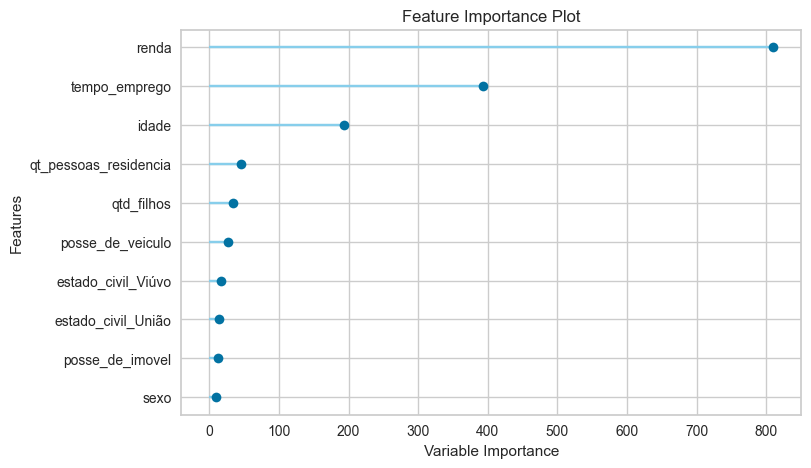

In [107]:
plot_model(tuned_lightgbm, plot='feature')

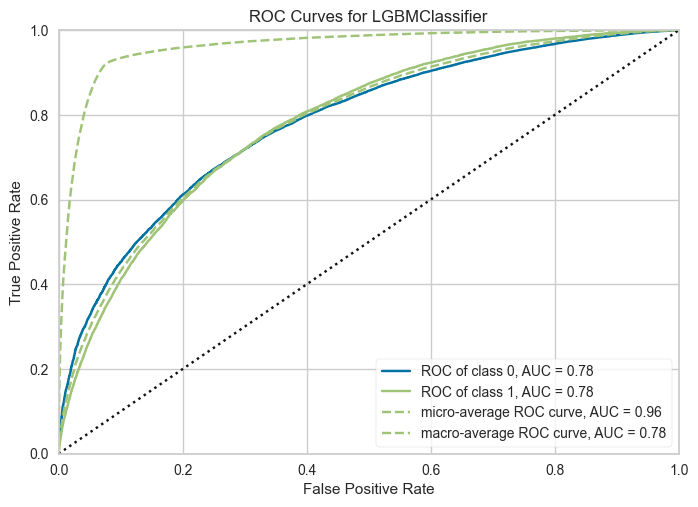

In [108]:
plot_model(tuned_lightgbm, plot='auc')

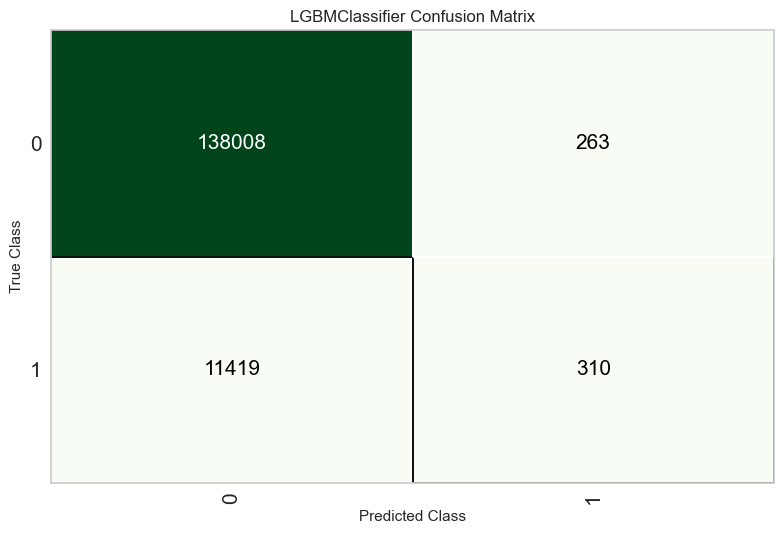

In [113]:
plot_model(tuned_lightgbm, plot='confusion_matrix')

In [109]:
# Prever nos dados não vistos
unseen_predictions = predict_model(tuned_lightgbm, data=data_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9241,0.7855,0.0302,0.5059,0.0570,0.0489,0.1095


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
0,F,S,S,2,Servidor público,Fundamental,Casado,Casa,38,15.643836,4.0,4758.299805,0,0,0.9278
1,M,N,S,1,Empresário,Médio,Casado,Casa,38,0.753425,3.0,2506.479980,0,0,0.8691
2,M,S,N,0,Empresário,Médio,Solteiro,Casa,44,1.260274,1.0,936.010010,0,0,0.7150
3,M,S,N,2,Assalariado,Médio,Casado,Casa,49,3.016438,4.0,3996.300049,0,0,0.9159
4,M,S,N,0,Empresário,Médio,Casado,Casa,39,0.827397,2.0,3908.919922,0,0,0.9098


In [115]:
check_metric(unseen_predictions['mau'], unseen_predictions['prediction_label'], metric = 'Accuracy')

0.9241

In [117]:
save_model(tuned_lightgbm, 'lightgbm_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))),
                 ('categorical_im...
                                 boosting

### Insights:
O uso do pipeline e do PyCaret melhorou significativamente os resultados em comparação com o exercício anterior. Confira abaixo algumas conclusões:
- Após o ajuste de hiperparâmetros, o modelo LightGBM apresentou uma acurácia média de 0.9223.
- O gráfico de importância das variáveis mostra que ``renda`` é de longe a variável mais importante, confirmando o que havíamos observado no gráfico de Feature Importance e Boruta.
- O modelo previu com uma acurácia de 0.9241 nosdados que não foram usados no treino.
- A matriz de confusão mostra que o modelo classificou corretamente 138.008 instâncias da classe 0 (adimplentes), com 263 falsos positivos.
- Para na classe 1 (inadimplentes), com 11.419 falsos negativos e 310 verdadeiros positivos.